In [1]:
import numpy as np
import pylab as plt
#from numpy import fft
import healpy as hp
from astropy.cosmology import Planck15, default_cosmology
from astropy import constants as const
from astropy import units as un
from astropy.coordinates import SkyCoord
import h5py
from scipy import signal
from astropy.io import ascii, fits

fft = np.fft.fft
fft2 = np.fft.fft2
ifft2 = np.fft.ifft2
fftshift = np.fft.fftshift
ifftshift = np.fft.ifftshift

## Defining the cosmology - Planck15 of astropy 
cosmo = Planck15
f21 = 1420.405752 * un.MHz # MHz
c = const.c.value # m/s
print('The 21 cm line emission freq - ',f21)

The 21 cm line emission freq -  1420.405752 MHz


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
%matplotlib inline

plt.rc('font', family='serif', weight='normal', size=22.0)
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')

import copy
COLORMAP = copy.copy(matplotlib.cm.__dict__["inferno"])
COLORMAP.set_under("black")
COLORMAP.set_bad("lightgray")

In [3]:
import os

In [4]:
import ps_tools as ps_tools

# Load Data

In [5]:
datapath_odd = '/project/def-mdobbs/arnab92/SKAD3/even_odd/newrun_band_6/oddts_image/'
datapath_even = '/project/def-mdobbs/arnab92/SKAD3/even_odd/newrun_band_6/events_image/'

In [6]:
data_even = os.path.join(datapath_even,'combined_even_cube_band6.fits')
data_odd = os.path.join(datapath_odd,'combined_odd_cube_band6.fits')

In [7]:
hdu_e = fits.open(data_even)[0]
hdu_o = fits.open(data_odd)[0]

In [8]:
hdr_e = hdu_e.header

In [9]:
image_even = np.array(hdu_e.data[:])
image_odd = np.array(hdu_o.data[:])

In [10]:
nfreq, Nx, Ny = image_even.shape

In [11]:
# Freq array of the data
freq0 = hdr_e.get('CRVAL3') # First freq channel value in Hz
chan_res = hdr_e.get('CDELT3') # chan res in Hz
freq = freq0 + chan_res * (np.arange(nfreq)) # The freq array in Hz
print(f"freq range : {freq[0]/1e6} to {freq[-1]/1e6} MHz")
print(f" Chan res : {chan_res/1e6} MHz")

freq range : 181.1 to 196.0 MHz
 Chan res : 0.1 MHz


In [12]:
# Resolution of the image
dx = hdr_e.get('CDELT1') # pixel size in X-direction, in deg
dy = hdr_e.get('CDELT2') # pixel size in Y-direction , in deg
print(f'pixel size in X and Y directions are, dx:{abs(dx*3600)} arcsec and dy:{abs(dy*3600)} arcsec')


pixel size in X and Y directions are, dx:15.99999999999984 arcsec and dy:15.99999999999984 arcsec


In [13]:
DEC_c = hdr_e.get('CRVAL2')
RA_c = hdr_e.get('CRVAL1')
cdelta2 = hdr_e.get('CDELT2')
cdelta1 = hdr_e.get('CDELT1')
DEC = np.arange((DEC_c-(cdelta2*Ny/2.)) , (DEC_c+(cdelta2*Ny/2.)), cdelta2)
RA = np.arange((RA_c-(cdelta1*Nx/2.)) , (RA_c+(cdelta1*Nx/2.)), cdelta1)

print(f'RA size: {RA.size} and DEC size {DEC.size}')

print(f"RA range : {RA[0]} to {RA[-1]}")
print(f"DEC range : {DEC[0]} to {DEC[-1]}")

RA size: 2048 and DEC size 2048
RA range : 4.551111111111066 to -4.546666666666315
DEC range : -4.551111111111066 to 4.546666666666315


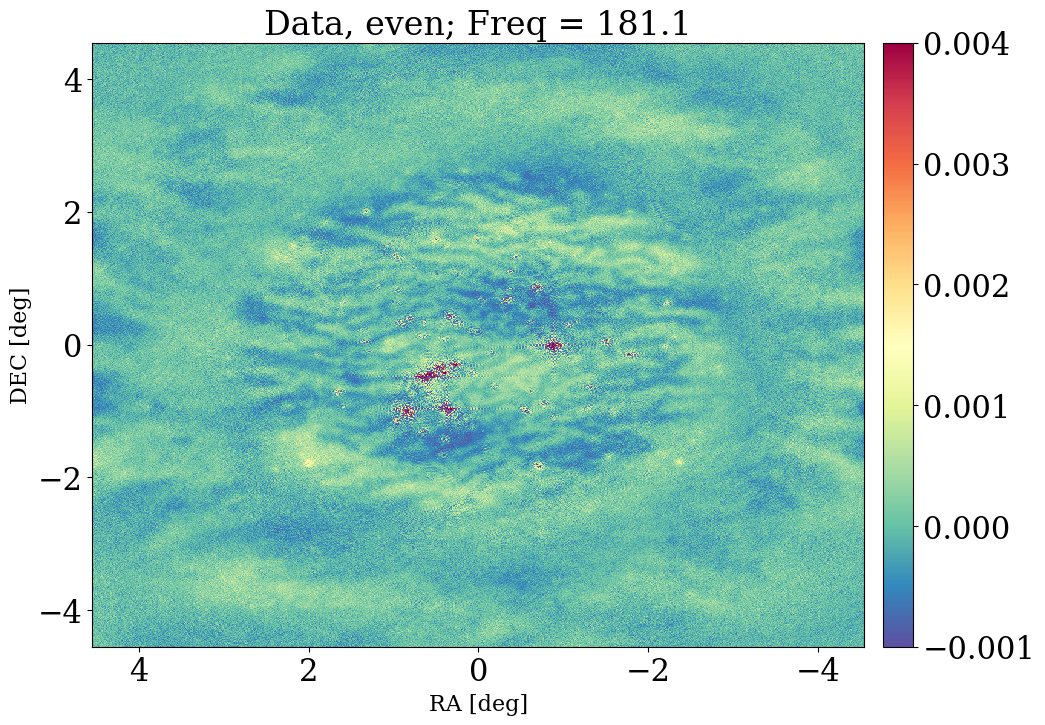

In [14]:
ext=(RA[0],RA[-1], DEC[0], DEC[-1])
imshow_kwargs = dict(aspect='auto', origin='lower', interpolation='nearest', 
                     extent=ext, cmap='Spectral_r',vmin=-0.001,vmax=0.004,)
plt.figure(figsize=(12,8),dpi=100)
nu_id = 0
im = plt.imshow(image_even[nu_id,:,:],**imshow_kwargs)
plt.xlabel("RA [deg]",fontsize=16)
plt.ylabel('DEC [deg]',fontsize=16)
plt.title(f'Data, even; Freq = {freq[nu_id]/1e6}',fontsize=24)
plt.colorbar(orientation='vertical',pad=0.02)

# Apply GPR 


In [15]:
Im = image_odd.reshape(nfreq,Nx * Ny)
print(Im.shape)

(150, 4194304)


In [16]:
Cov = np.cov(Im) # estimate the freq covariance

In [17]:
print(Cov.shape)

(150, 150)


In [18]:
Cov.min()

1.7536594578775968e-08

Text(0, 0.5, 'Freq')

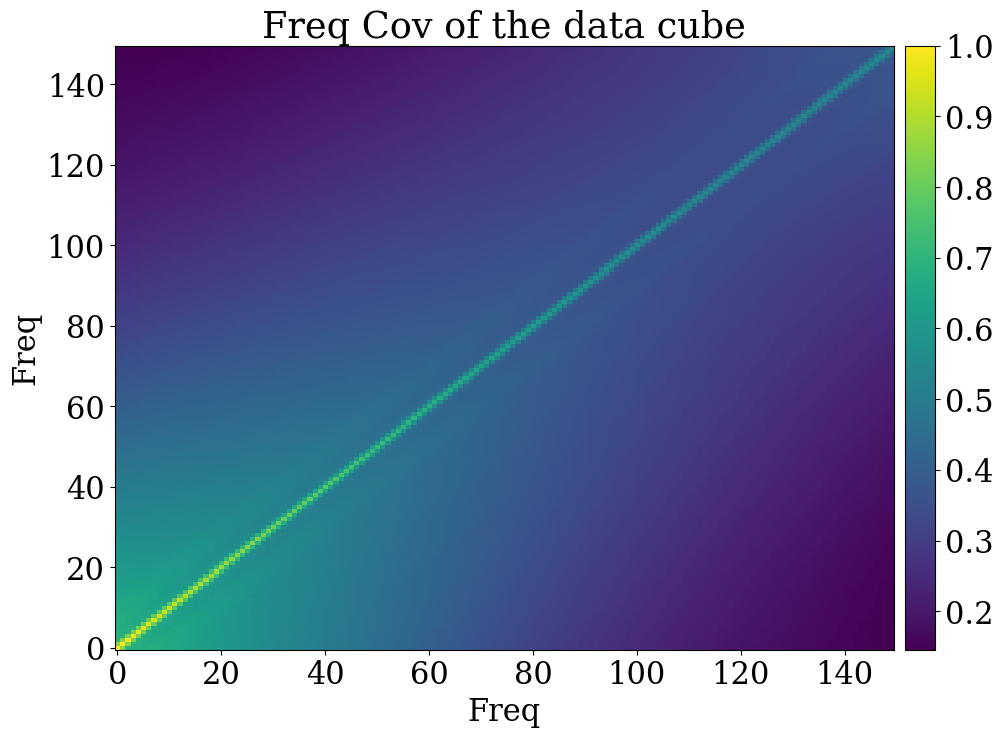

In [19]:
fig = plt.figure(figsize=(12,8),dpi=100)
plt.imshow(Cov/Cov.max(), origin='lower', aspect='auto')
plt.colorbar(pad=0.012)
plt.title('Freq Cov of the data cube')
plt.xlabel('Freq')
plt.ylabel('Freq')

# Define the GPR kernels

In [20]:
import GPy

In [21]:
# kernel for the smooth foreground:
kern_fg_sky = GPy.kern.RBF(1)
kern_fg_mix = GPy.kern.Matern52(1)
kern_fg_ex = GPy.kern.Matern32(1)


# kernel for the HI cosmological signal:
kern_21 = GPy.kern.Exponential(1)

In [22]:
# setting priors for the smooth foreground kernel:
kern_fg_sky.variance.constrain_bounded(1e4,1e7)
kern_fg_sky.lengthscale.constrain_bounded(6,20)

kern_fg_mix.variance.constrain_bounded(1e1,1e2)
kern_fg_mix.lengthscale.constrain_bounded(4,8)

kern_fg_ex.variance.constrain_bounded(1e-1,5e0)
kern_fg_ex.lengthscale.constrain_bounded(2,6)

# setting priors for the HI kernel:
kern_21.variance.constrain_bounded(1e-4,5e-1)
kern_21.lengthscale.constrain_bounded(0.4,1.)

reconstraining parameters rbf.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat32.variance
reconstraining parameters Mat32.lengthscale
reconstraining parameters Exponential.variance
reconstraining parameters Exponential.lengthscale


In [23]:
# Define the FG kernel
kern_fg = kern_fg_sky + kern_fg_mix + kern_fg_ex

In [24]:
freq_MHz = freq/1e6

In [25]:
# GPR parameteres
num_restarts = 0
NprePCA = 0
zero_noise = False
heteroscedastic = True
invert = False
num_processes = 1

In [26]:
import time
import pandas as pd

In [27]:
# Now run GPR using RBF kernel + mix
# My implementation of GPR 

t0 = time.time()
gpr_data_cube_even = ps_tools.gpr_fg_clean(image_even, freq_MHz,k_fg_sky= kern_fg,k_HI= kern_21, nPCA=NprePCA,
                          num_restarts=num_restarts,noise_data=None, heteroscedastic=heteroscedastic, 
                          zero_noise=zero_noise, invert=invert)
t1 = time.time()
print((t1-t0)/60.)

FG kernels length 3
The foreground kernels are   sum.               |      value  |     constraints      |  priors
  rbf.variance       |  5005000.0  |  10000.0,10000000.0  |        
  rbf.lengthscale    |       13.0  |       6.0,20.0       |        
  Mat52.variance     |       55.0  |      10.0,100.0      |        
  Mat52.lengthscale  |        6.0  |       4.0,8.0        |        
  Mat32.variance     |        1.0  |       0.1,5.0        |        
  Mat32.lengthscale  |        4.0  |       2.0,6.0        |        
1.0876244266827901


In [28]:
gpr_res_cube_even = gpr_data_cube_even.res
fg_cov_cube_even = gpr_data_cube_even.fgcov
fg_fit_cube_even = gpr_data_cube_even.fgfit
model_cube_even = gpr_data_cube_even.model
print(gpr_res_cube_even.shape)

(150, 2048, 2048)


Text(0, 0.5, 'Freq')

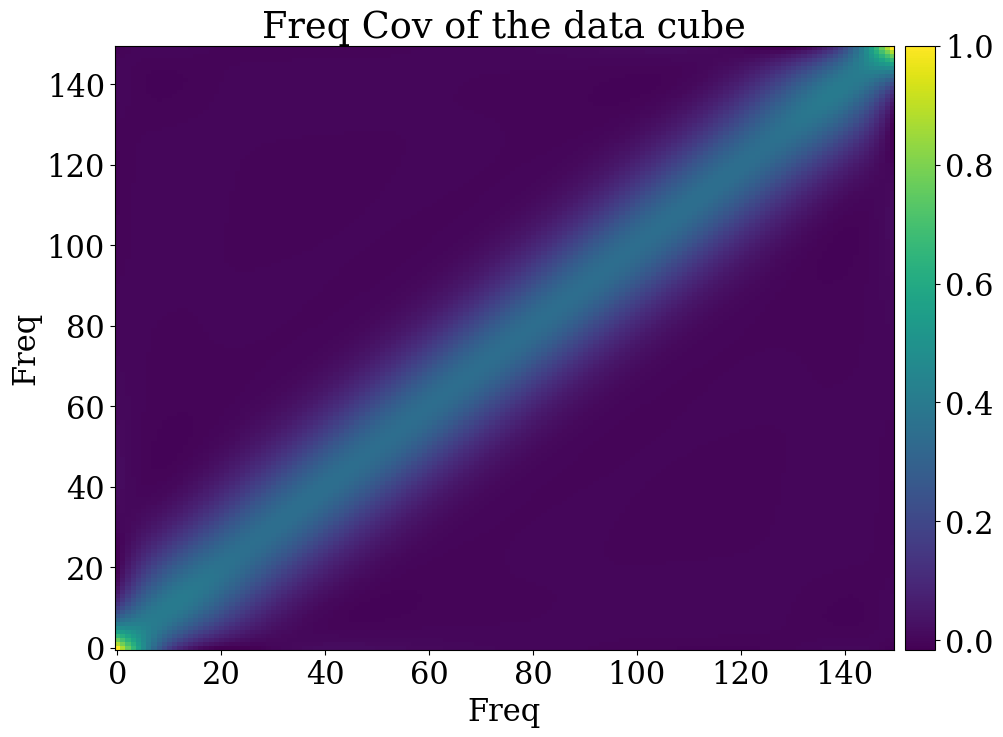

In [29]:
fig = plt.figure(figsize=(12,8),dpi=100)
plt.imshow(fg_cov_cube_even/fg_cov_cube_even.max(), origin='lower', aspect='auto')
plt.colorbar(pad=0.012)
plt.title('Freq Cov of the data cube')
plt.xlabel('Freq')
plt.ylabel('Freq')

In [30]:
# n_pix = Ny * Nx
# mu = np.zeros(nfreq) # vector of the means, zero
# n_samples = 3 # number of samples we want to generate and later average over

# # Generate n separate samples paths from a Gaussian with mean mu and covariance fg_cov:
# samples = []
# for i in range(n_samples):
#     s = np.random.multivariate_normal(mu, fg_cov_cube_even, (Ny, Nx))
#     print(s.shape)
#     samples.append(s)

# samples = np.array(samples)

In [31]:
# Now run GPR using RBF kernel + mix
# My implementation of GPR 

t0 = time.time()
gpr_data_cube_odd = ps_tools.gpr_fg_clean(image_odd, freq_MHz,k_fg_sky= kern_fg,k_HI= kern_21, nPCA=NprePCA,
                          num_restarts=num_restarts,noise_data=None, heteroscedastic=heteroscedastic, 
                          zero_noise=zero_noise, invert=invert)
t1 = time.time()
print((t1-t0)/60.)

FG kernels length 3
The foreground kernels are   sum.               |      value  |     constraints      |  priors
  rbf.variance       |  5005000.0  |  10000.0,10000000.0  |        
  rbf.lengthscale    |       13.0  |       6.0,20.0       |        
  Mat52.variance     |       55.0  |      10.0,100.0      |        
  Mat52.lengthscale  |        6.0  |       4.0,8.0        |        
  Mat32.variance     |        1.0  |       0.1,5.0        |        
  Mat32.lengthscale  |        4.0  |       2.0,6.0        |        
1.471727228164673


In [32]:
gpr_res_cube_odd = gpr_data_cube_odd.res
fg_cov_cube_odd = gpr_data_cube_odd.fgcov
fg_fit_cube_odd = gpr_data_cube_odd.fgfit
model_cube_odd = gpr_data_cube_odd.model
print(gpr_res_cube_odd.shape)

(150, 2048, 2048)


In [33]:
fg_cov_cube_odd.shape,fg_fit_cube_odd.shape

((150, 150), (150, 2048, 2048))

In [34]:
del gpr_data_cube_even, gpr_data_cube_odd

Text(0, 0.5, 'Freq')

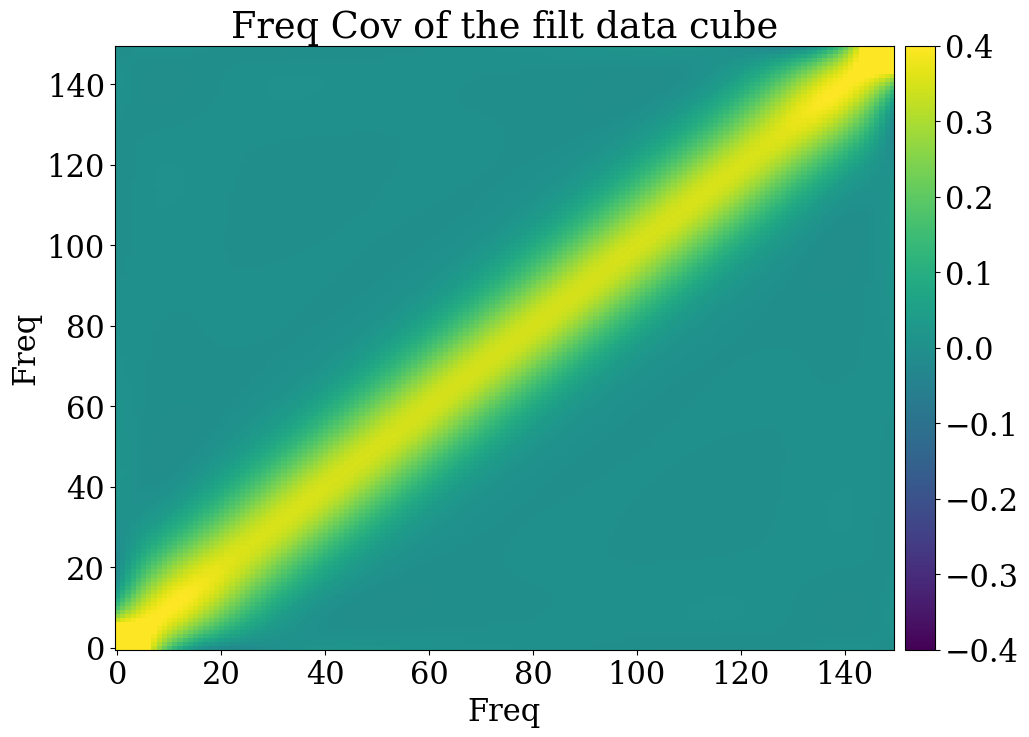

In [35]:
fig = plt.figure(figsize=(12,8),dpi=100)
plt.imshow(fg_cov_cube_odd/fg_cov_cube_odd.max(),vmin=-0.4,vmax=0.4, origin='lower', aspect='auto')
plt.colorbar(pad=0.012)
plt.title('Freq Cov of the filt data cube')
plt.xlabel('Freq')
plt.ylabel('Freq')

([], [])

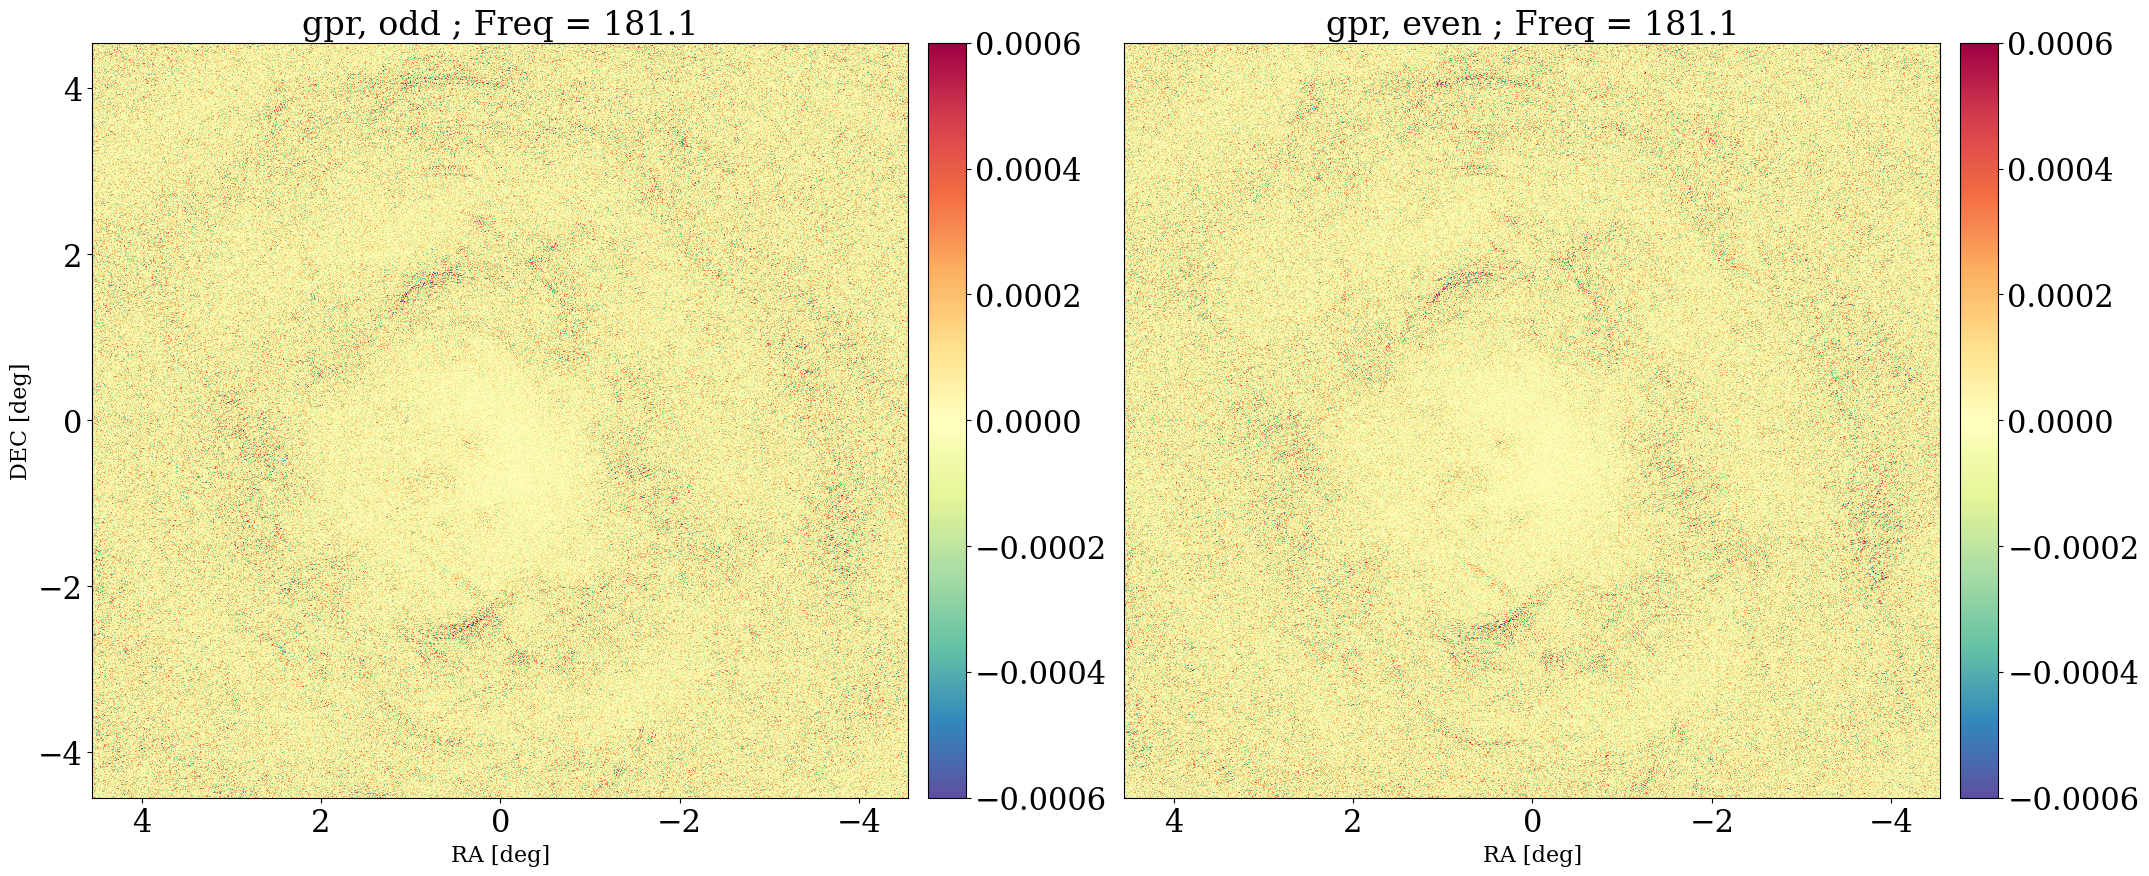

In [36]:
ext=(RA[0],RA[-1], DEC[0], DEC[-1])
imshow_kwargs = dict(aspect='auto', origin='lower', interpolation='nearest', 
                     extent=ext,)


fig = plt.figure(num=1, figsize=(26, 10), dpi=100)

gspec = gridspec.GridSpec(1, 2, wspace=0.05)
  
plt.subplot(gspec[0, 0])
plt.imshow(gpr_res_cube_odd[nu_id,:,:],vmin=-6e-4,vmax=6e-4,**imshow_kwargs,cmap='Spectral_r')
plt.xlabel("RA [deg]",fontsize=16)
plt.ylabel('DEC [deg]',fontsize=16)
plt.title(f'gpr, odd ; Freq = {freq[nu_id]/1e6}',fontsize=24)
plt.colorbar(orientation='vertical',pad=0.02)


plt.subplot(gspec[0, 1])
plt.imshow(gpr_res_cube_even[nu_id,:,:],vmin=-6e-4,vmax=6e-4,**imshow_kwargs,cmap='Spectral_r')
plt.xlabel("RA [deg]",fontsize=16)
plt.title(f'gpr, even ; Freq = {freq[nu_id]/1e6}',fontsize=24)
plt.colorbar(orientation='vertical',pad=0.02)
plt.yticks([])

# Load the primary beam 

In [37]:
# Load the primary beam 
path = '/project/def-mdobbs/arnab92/SKAD3/data/beam_Sub_bands'
beam = os.path.join(path,'SKA_beam_sub_6_181_196_MHz.fits')

In [38]:
hdu_beam = fits.open(beam)[0]

In [39]:
hdr_beam = hdu_beam.header

In [40]:
# hdr_beam

In [41]:
nfreq_beam = hdr_beam['NAXIS3']

In [53]:
beam = np.array(hdu_beam.data[:])

In [54]:
beam.shape,image_even.shape

((151, 2560, 2560), (150, 2048, 2048))

# Now take the beam of same shape as image
# Note that, the primary beam image is larger than the actual image

In [55]:
im_size_deg = abs(hdr_e['CDELT1']) * Nx # image size in deg
im_size_deg

9.102222222222132

In [56]:
# Make the beam image same as data image
theta_fov = im_size_deg # deg
res = abs(np.radians(hdr_beam['CDELT1']))
fov = np.radians(theta_fov)
fov_sin = 2 * np.sin(fov / 2.)

In [57]:
n = fov_sin / res
idx = int((beam.shape[1] - n) / 2.)-1
idx

256

In [58]:
# Trimmed central 4deg map
pb_map = beam[1:, idx:-idx, idx:-idx]

In [59]:
pb_map.shape

(150, 2048, 2048)

In [60]:
del beam

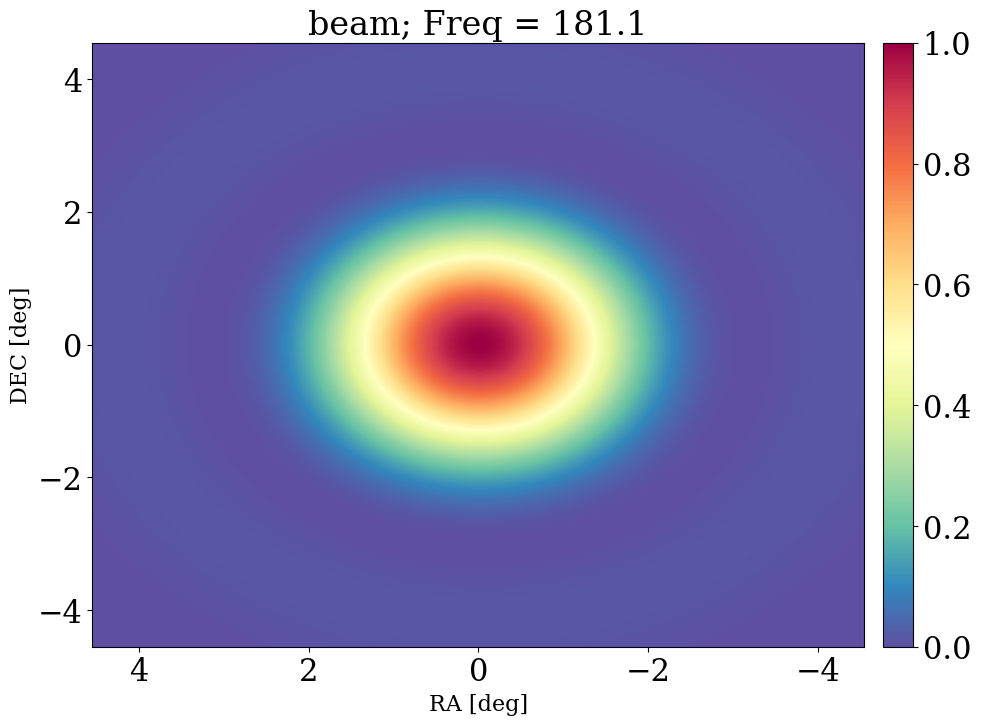

In [61]:
ext=(RA[0],RA[-1], DEC[0], DEC[-1])
imshow_kwargs = dict(aspect='auto', origin='lower', interpolation='nearest', 
                    extent=ext,  cmap='Spectral_r')

plt.figure(figsize=(12,8),dpi=100)
nu_id = 0
im = plt.imshow(pb_map[nu_id,:,:],**imshow_kwargs,vmin=0,vmax=1)
plt.xlabel("RA [deg]",fontsize=16)
plt.ylabel('DEC [deg]',fontsize=16)
plt.title(f'beam; Freq = {freq[nu_id]/1e6}',fontsize=24)
plt.colorbar(orientation='vertical',pad=0.02)

In [62]:
# Divide the data by primary beam
data_filt_pb_even = np.divide(gpr_res_cube_even,pb_map)
data_filt_pb_odd = np.divide(gpr_res_cube_odd,pb_map)

([], [])

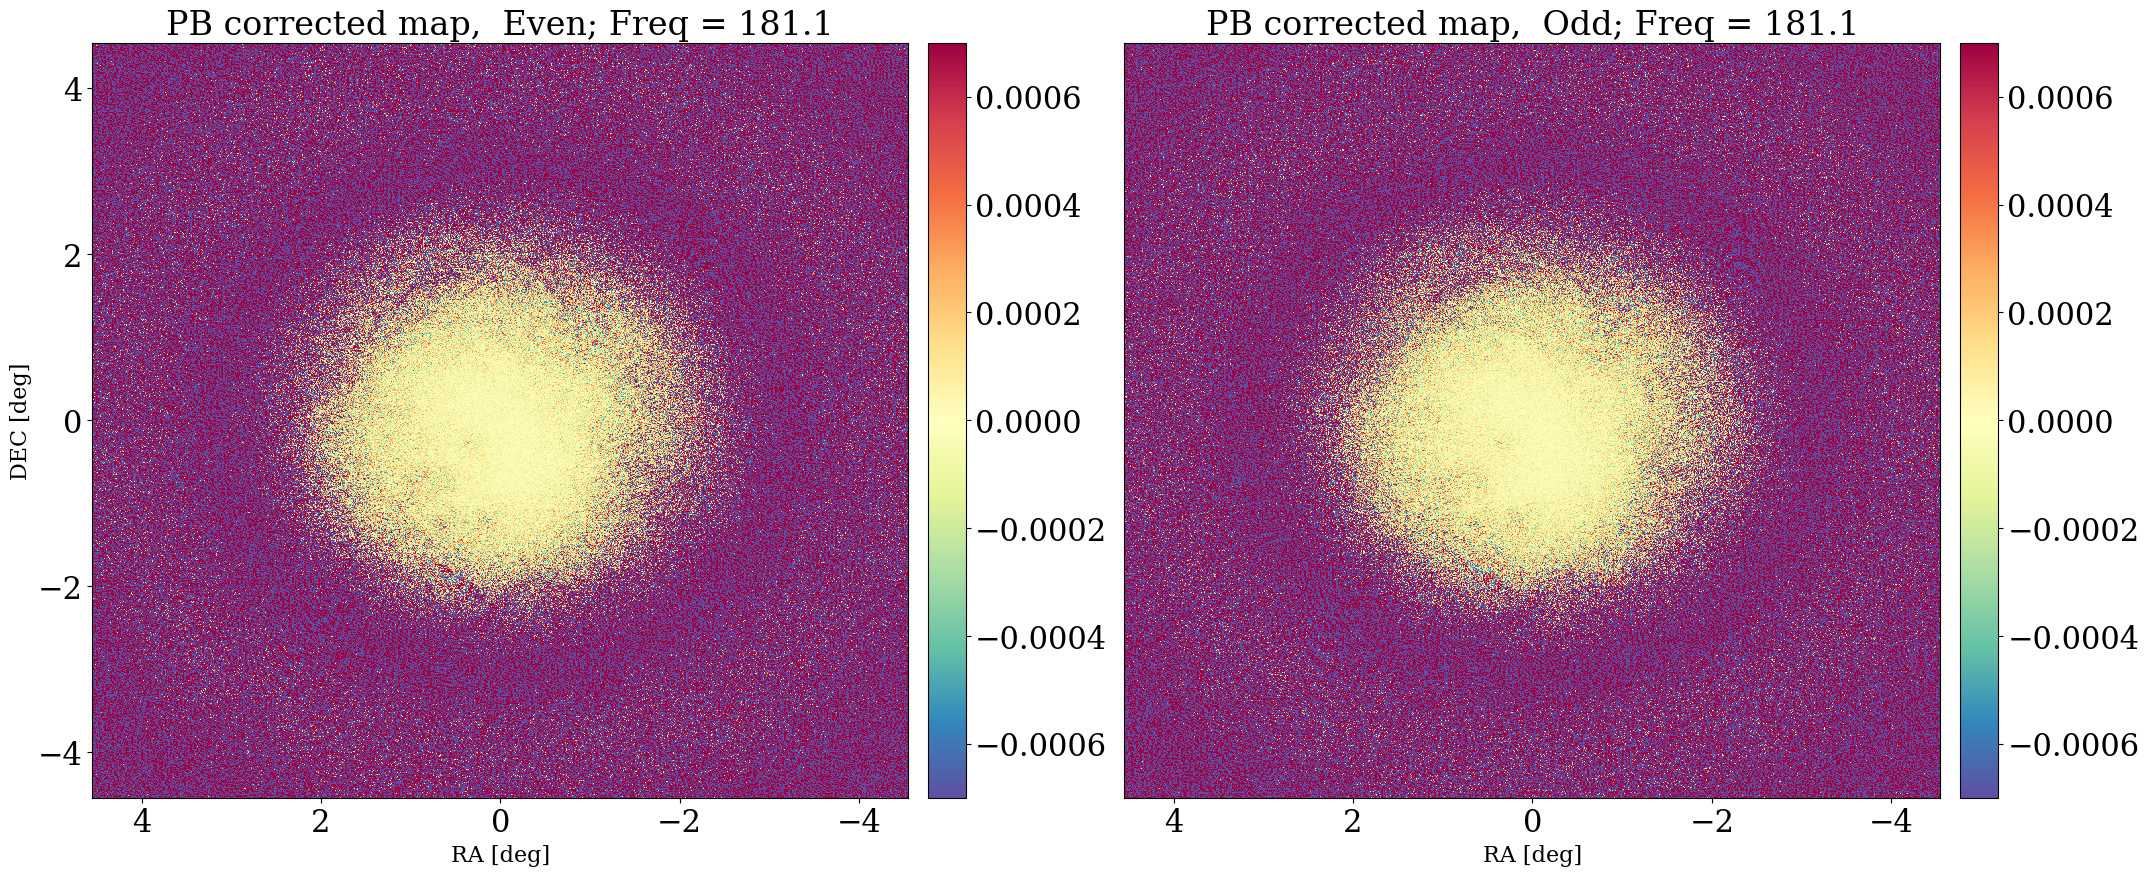

In [63]:
ext=(RA[0],RA[-1], DEC[0], DEC[-1])
imshow_kwargs = dict(aspect='auto', origin='lower', interpolation='nearest', 
                     extent=ext, cmap='Spectral_r')


fig = plt.figure(num=1, figsize=(26, 10), dpi=100)

gspec = gridspec.GridSpec(1, 2, wspace=0.05)
  
plt.subplot(gspec[0, 0])
plt.imshow(data_filt_pb_even[nu_id,:,:],vmin=-7e-4,vmax=7e-4,**imshow_kwargs)
plt.xlabel("RA [deg]",fontsize=16)
plt.ylabel('DEC [deg]',fontsize=16)
plt.title(f'PB corrected map,  Even; Freq = {freq[nu_id]/1e6}',fontsize=24)
plt.colorbar(orientation='vertical',pad=0.02)


plt.subplot(gspec[0, 1])
plt.imshow(data_filt_pb_odd[nu_id,:,:],vmin=-7e-4,vmax=7e-4,**imshow_kwargs)
plt.xlabel("RA [deg]",fontsize=16)
plt.title(f'PB corrected map,  Odd; Freq = {freq[nu_id]/1e6}',fontsize=24)
plt.colorbar(orientation='vertical',pad=0.02)
plt.yticks([])

# Jy/beam to kelvin conversion

In [64]:
# Central freq and redshift
nu_c = freq[int(freq.size/2.0)]/1e6 # in MHz
print(f'The central freq is {nu_c} MHz')

wl = c/(nu_c*1e6) # nu_c is the freq of the map in MHz
print(f'The wavelength :  {wl} m')

redshift = f21.value/nu_c - 1
print('Redshift = ',redshift)

bl_max = 2500. # Max baseline in m
PSF = wl/bl_max 
PSF_arcsec = np.degrees(PSF) * 3600 # in arcsec
print(f'The PSF size : {PSF_arcsec} arcsec')

omega_psf = (np.pi * PSF_arcsec**2)/((4*np.log(2)))# Bmaj=Bmin= PSF_arcsec;beam_area = (pi * Bmaj * Bmin)/(4 * log(2))
omega_psf_sr = (omega_psf*un.arcsec**2).to('sr')
print(f'PSF area ={omega_psf_sr}')

jybeam2k_factor = ps_tools.jy_per_beam_to_kelvin(freq/1e6,omega_psf_sr)
print(f'The mean conversion factor from Jy/bm to K at this freq is {np.mean(jybeam2k_factor)}')

The central freq is 188.6 MHz
The wavelength :  1.5895676458112407 m
Redshift =  6.531313637327678
The PSF size : 131.14874499196347 arcsec
PSF area =4.580811616732241e-07 sr
The mean conversion factor from Jy/bm to K at this freq is 2001.798175298075


In [65]:
# Take the central 2 deg of the pb_corrected image 
theta_fov = 2 # deg
res = abs(np.radians(hdr_e['CDELT1']))
fov = np.radians(theta_fov)
fov_sin = 2 * np.sin(fov / 2.)
n = fov_sin / res
idx = int((Nx - n) / 2.)

In [66]:
cart_map_filt_kelvin_even = data_filt_pb_even[:, idx:-idx, idx:-idx] * jybeam2k_factor[:,None,None]
cart_map_filt_kelvin_odd = data_filt_pb_odd[:, idx:-idx, idx:-idx] * jybeam2k_factor[:,None,None]

In [67]:
del data_filt_pb_even, data_filt_pb_odd

In [68]:
# The 2 deg RA and DEC range
ra = RA[idx:-idx]
dec = DEC[idx:-idx]

In [69]:
# ext=(ra[0],ra[-1], dec[0], dec[-1])
# imshow_kwargs = dict(aspect='auto', origin='lower', interpolation='nearest', 
#                      extent=ext, cmap='Spectral_r')

# nu_id = 5

# plt.figure(figsize=(12,8),dpi=100)
# im = plt.imshow(cart_map_filt_even[nu_id,:,:],vmin=-6e-4,vmax=6e-4,**imshow_kwargs)
# plt.xlabel("RA [deg]",fontsize=16)
# plt.ylabel('DEC [deg]',fontsize=16)
# plt.title(f'PB corrected image, central 2deg; Freq = {freq[nu_id]/1e6}',fontsize=16)
# plt.colorbar(orientation='vertical',pad=0.02)

In [70]:
def powerspec_cross(data_cube_1,data_cube_2,freq,redshift,wl,chan_res,pixel_res,kperp_bins,kpar_bins,
                  apply_spectral_window = True,u_min=20.0,u_max=80.0,Nbins_2D=50,
                  
                  log_bins=False):
    
    '''
    Input:
          data_cube_1 : the data_cube_1 of shape (Nz,Ny,Nx)
          data_cube_2: the data_cube_2 of shape (Nz,Ny,Nx)
          redshift : Redshift of the band center. float.
          wl : wavelength corresponding to the band center. float.
          chan_res : The channel width in Hz. float.
          pixel_res: The pixel resolution of the map in deg.
          apply_spectral_window : Apply a spectral window before taking delay transform. bool.
          u_min : The minimum baseline length in meter to include in PS binning. default = 20m
          u_max : The minimum baseline length in meter to include in PS binning. default = 80m
          Nbins_2D : The number of bins in 2D cylinfrical binning.
          kperp_bins: The bins provided by SKA group, along kperp.
          kpar_bins: The bins provided by SKA group, along kpar
          log_bins : Take log bins along kperp, if true. bool.
          
    Return: kperp : k_perpendicular [Mpc^-1], in the bins provided by SKA group.
            kl : k_parallel [Mpc^-1], in the bins provided by SKA group.
            ps_2D : The 2D PS, in the bins provided by SKA group.
            ps_2D_err : TThe 2D PS err, in the bins provided by SKA group.
            k_perp : k_perpendicular [Mpc^-1], with coarser bins
            k_par : k_parallel [Mpc^-1], with coarser bins
            ps_2D_no_kpar: The 2D PS, with coarser bins.
    
    '''
    import scipy.signal.windows as windows
    window_name = 'nuttall'
    nfreq= freq.size

   
    # Transform to vis domain -- data
    data_uv_nu_1 = ps_tools.image_to_uv(data_cube_1, window=False,axes=(1,2))
    data_uv_nu_2 = ps_tools.image_to_uv(data_cube_2, window=False,axes=(1,2))
    
    # Transform to delay
    
    if apply_spectral_window:  
        # Generate a blackmanharris window to apodisation 
        window = windows.get_window(window_name,nfreq)
        w = window[:,np.newaxis,np.newaxis]
        
        data_uv_tau_1 =  np.fft.fftshift(np.fft.ifft(data_uv_nu_1 * w,axis=0),axes=0)    
        data_uv_tau_2 =  np.fft.fftshift(np.fft.ifft(data_uv_nu_2 * w,axis=0),axes=0)    
    else:
        data_uv_tau_1 =  np.fft.fftshift(np.fft.ifft(data_uv_nu_1,axis=0),axes=0)
        data_uv_tau_2 =  np.fft.fftshift(np.fft.ifft(data_uv_nu_2,axis=0),axes=0)
    
    # Fourier modes 
    delays = np.fft.fftshift(np.fft.fftfreq(nfreq, d= chan_res)) # * un.s # in s
    tau = delays * 1e6 # in mu-s         
    k_parallel = ps_tools.delay_to_kpara(delays * un.s,redshift,cosmo=cosmo)
    
    theta_res = np.deg2rad(abs(pixel_res)) # pixel res (deg->rad), taking the mean resolution
    
    # shape of the trimmed data cube
    nx = data_uv_tau_1.shape[1]
    ny = data_uv_tau_1.shape[2]
    
    kx, ky, u, v = ps_tools.get_spatial_kmodes(nx,ny,theta_res,redshift)
    k_perp = np.sqrt(kx[:,np.newaxis]**2 + ky[np.newaxis,:] **2)  # [Mpc^-1]

    # The volume normalization
    dfreq = chan_res/1e6 # chan res in MHz
    # The volume normalization
    vol_norm = ps_tools.vol_normalization_vis(Nx = nx, Ny = ny, Nz = nfreq, 
                                      theta_res = theta_res, redshift=redshift,chan_width = dfreq)
    
    print(f'volume normalization = {vol_norm}')
    
    # Take the 3D correlation, between data_1 and data_2, and normalize by the volume of the survey.
    # We take the real part only.
    data_corr_real = ps_tools.get_ps(data_uv_tau_1,vis_cube_2=data_uv_tau_2,vol_norm_factor=(vol_norm))
    
    # SKA baselines choice for Power spectrum estimation 
    u_min_lambda = u_min/wl; u_max_lambda = u_max/wl
    kperp_min = ps_tools.u_to_kperp(u_min_lambda,redshift,cosmo=cosmo)
    kperp_max = ps_tools.u_to_kperp(u_max_lambda,redshift,cosmo=cosmo)

    print(f'Min baseline: {u_min} m, Max baseline: {u_max} m,z: {redshift}, Wavelength:{wl} m')
    print(f'Min bl in wavelength unit: {u_min_lambda},Max bl: {u_max_lambda}')
    print(f'Min kperp: {kperp_min}, Max kperp: {kperp_max}')   

    # keep the non-zero visibilities between minimum and maximum baseline for each delay channel
    # also, take the flatten array; i.e, the out put is (ntau,nvis),
    # where nvis is number of vis between two limit

    data_corr, uu, vv,  = ps_tools.reshape_data_cube(data_corr_real,u,v,u_min_lambda, u_max_lambda)
    
    print('Cylindrical averaging of real PS')
    
    kperp,kl,ps_2D,ps_2D_w,ps_2D_err  = ps_tools.PS2D(data_corr,weight_cube=None,kperp_bins=kperp_bins,
                                    kpar_bins=kpar_bins,
                                    kpar=k_parallel.value, uu = uu, vv = vv,redshift=redshift,
                                    )
    # With no binning along k_par
    k_perp,k_par,ps_2D_no_kpar,_,_ = ps_tools.PS2D_no_kpar_bin(data_corr,weight_cube=None,
                    kperp_min=kperp_min.value,kperp_max=kperp_max.value,kpar=k_parallel.value,
                    uu=uu,vv=vv,redshift=redshift,fold=True,
                    Nbins_2D=Nbins_2D,log_bins=log_bins)
    
    
    return kperp,kl,ps_2D,ps_2D_err,k_perp,k_par,ps_2D_no_kpar

In [71]:
redshift

6.531313637327678

In [72]:
# The true kperp and kpar bins
kperp_bins = np.loadtxt(os.path.join("/project/def-mdobbs/arnab92/SKAD3/test_data","bins_kper.txt"))
kpar_bins = np.loadtxt(os.path.join("/project/def-mdobbs/arnab92/SKAD3/test_data","bins_kpar.txt"))

In [73]:
umin = 35.0 # m 
umax = 2000.0 # m 

In [74]:
kperp,kl,ps_2D,ps_2D_err,k_perp,k_par,ps_2D_no_kpar = powerspec_cross(data_cube_1 =cart_map_filt_kelvin_even,
                  data_cube_2 = cart_map_filt_kelvin_odd,freq = freq,redshift=redshift,wl=wl,
                  chan_res = chan_res,pixel_res=dx,kperp_bins=kperp_bins,kpar_bins=kpar_bins,
                  apply_spectral_window = False,u_min=umin,u_max=umax,Nbins_2D=50,
                  log_bins=False)

Fourier Norm : 4.938271604938272e-06
Fourier Norm : 4.938271604938272e-06
Linear size in X-direction = 301.96045005087433 Mpc
Linear size in Y-direction = 301.96045005087433 Mpc
Linear size in Z-direction = 229.94323336733993 Mpc
Power Spectrum normalization factor  value - 20966250.092830118 Mpc^3
volume normalization = 20966250.092830118
correlate the vis cube 1 with vis cube 2
Min baseline: 35.0 m, Max baseline: 2000.0 m,z: 6.531313637327678, Wavelength:1.5895676458112407 m
Min bl in wavelength unit: 22.018565924030018,Max bl: 1258.2037670874295
Min kperp: 0.015992862281789075 1 / Mpc, Max kperp: 0.9138778446736614 1 / Mpc
Gridded data cube shape in kx and ky direction - (450, 450)
Cylindrical averaging of real PS
Using unit uniform weighting
(6048,)
Using unit uniform weighting
Using linear binning in k_perp between 0.015992862281789075 and 0.9138778446736614
(6048,)


# Error estimation 

In [75]:
_,_,_,ps_2D_err_1,_,_,_ = powerspec_cross(data_cube_1 =cart_map_filt_kelvin_even,
                  data_cube_2 = cart_map_filt_kelvin_even,freq = freq,redshift=redshift,wl=wl,
                  chan_res = chan_res,pixel_res=dx,kperp_bins=kperp_bins,kpar_bins=kpar_bins,
                  apply_spectral_window = False,u_min=umin,u_max=umax,Nbins_2D=50,
                  log_bins=False)

Fourier Norm : 4.938271604938272e-06
Fourier Norm : 4.938271604938272e-06
Linear size in X-direction = 301.96045005087433 Mpc
Linear size in Y-direction = 301.96045005087433 Mpc
Linear size in Z-direction = 229.94323336733993 Mpc
Power Spectrum normalization factor  value - 20966250.092830118 Mpc^3
volume normalization = 20966250.092830118
correlate the vis cube 1 with vis cube 2
Min baseline: 35.0 m, Max baseline: 2000.0 m,z: 6.531313637327678, Wavelength:1.5895676458112407 m
Min bl in wavelength unit: 22.018565924030018,Max bl: 1258.2037670874295
Min kperp: 0.015992862281789075 1 / Mpc, Max kperp: 0.9138778446736614 1 / Mpc
Gridded data cube shape in kx and ky direction - (450, 450)
Cylindrical averaging of real PS
Using unit uniform weighting
(6048,)
Using unit uniform weighting
Using linear binning in k_perp between 0.015992862281789075 and 0.9138778446736614
(6048,)


In [76]:
_,_,_,ps_2D_err_2,_,_,_ = powerspec_cross(data_cube_1 =cart_map_filt_kelvin_odd,
                  data_cube_2 = cart_map_filt_kelvin_odd,freq = freq,redshift=redshift,wl=wl,
                  chan_res = chan_res,pixel_res=dx,kperp_bins=kperp_bins,kpar_bins=kpar_bins,
                  apply_spectral_window = False,u_min=umin,u_max=umax,Nbins_2D=50,
                  log_bins=False)

Fourier Norm : 4.938271604938272e-06
Fourier Norm : 4.938271604938272e-06
Linear size in X-direction = 301.96045005087433 Mpc
Linear size in Y-direction = 301.96045005087433 Mpc
Linear size in Z-direction = 229.94323336733993 Mpc
Power Spectrum normalization factor  value - 20966250.092830118 Mpc^3
volume normalization = 20966250.092830118
correlate the vis cube 1 with vis cube 2
Min baseline: 35.0 m, Max baseline: 2000.0 m,z: 6.531313637327678, Wavelength:1.5895676458112407 m
Min bl in wavelength unit: 22.018565924030018,Max bl: 1258.2037670874295
Min kperp: 0.015992862281789075 1 / Mpc, Max kperp: 0.9138778446736614 1 / Mpc
Gridded data cube shape in kx and ky direction - (450, 450)
Cylindrical averaging of real PS
Using unit uniform weighting
(6048,)
Using unit uniform weighting
Using linear binning in k_perp between 0.015992862281789075 and 0.9138778446736614
(6048,)


In [77]:
ps_2D_Error = np.sqrt(ps_2D_err_1 * ps_2D_err_2)

 <ipython-input-78-caf871ea1062>:3: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


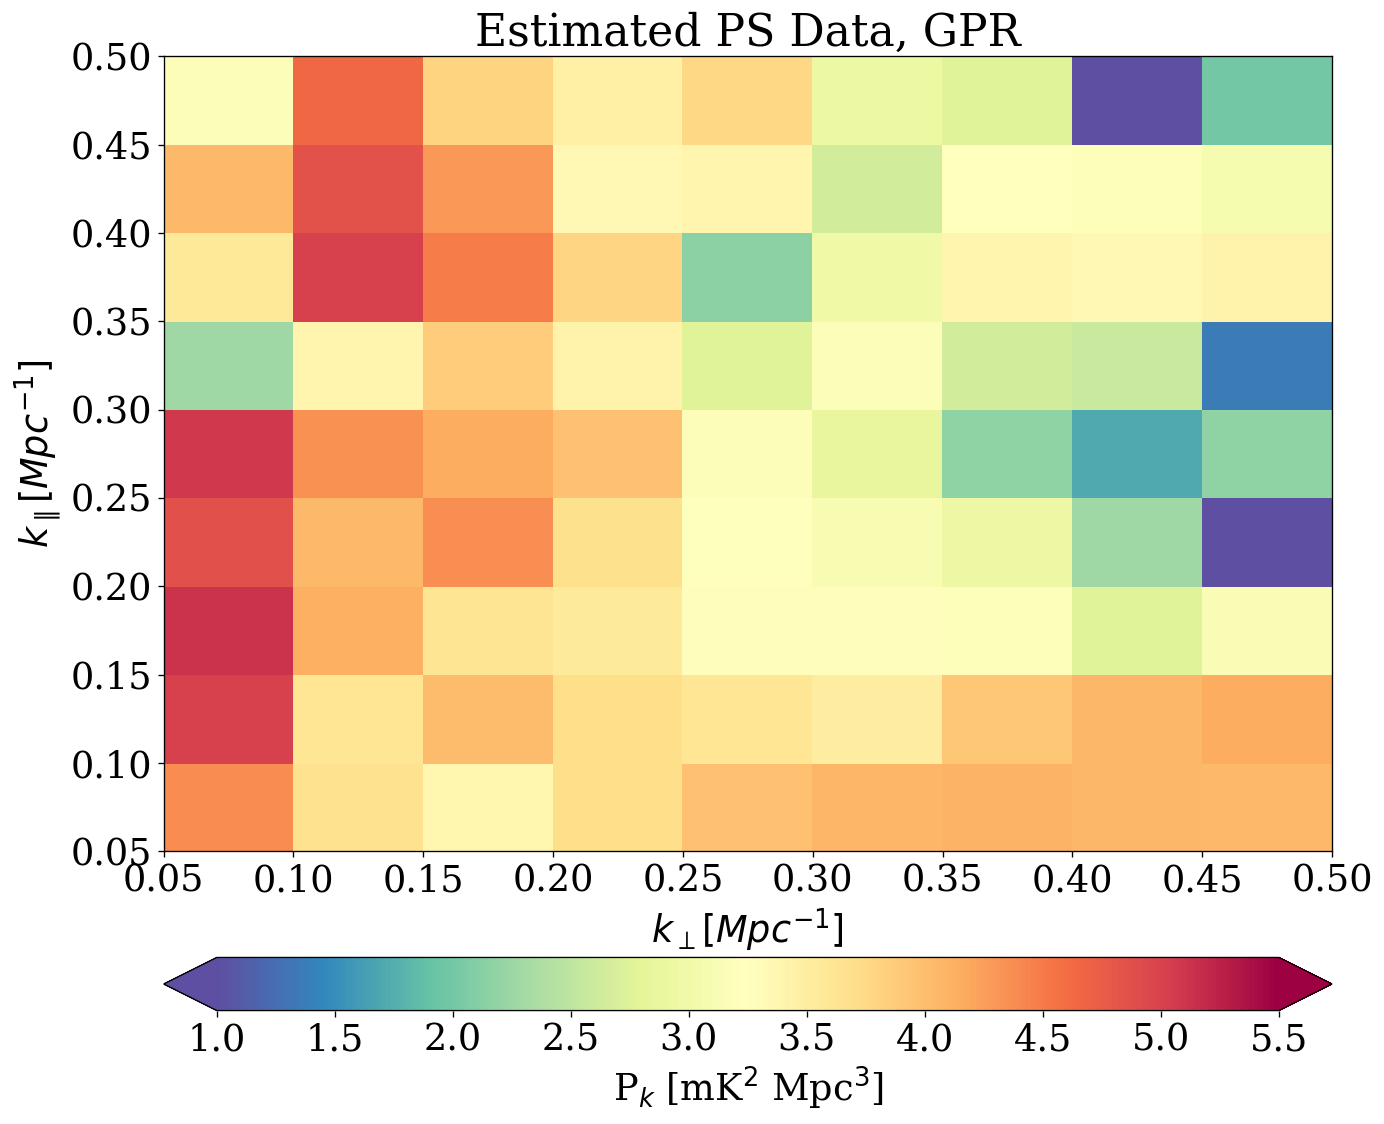

In [78]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=120)

im = ax.pcolormesh(kperp_bins, kpar_bins, np.log10(abs(ps_2D*1e6)),vmin=1,vmax=5.5,cmap = 'Spectral_r')


cbar = fig.colorbar(im, ax=ax, extend='both',pad=0.1, orientation='horizontal')

cbar.ax.minorticks_off()

cbar.set_label(r'P$_{k}$ [mK$^{2}$ Mpc$^{3}$]')
#ax.set_xscale('log')
plt.title('Estimated PS Data, GPR')
ax.set_xlabel(r'$k_{\perp} [Mpc^{-1}]$')
ax.set_ylabel(r'$k_{\parallel} [Mpc^{-1}]$')
plt.tight_layout()
plt.show()

 <ipython-input-79-f3010921de00>:3: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


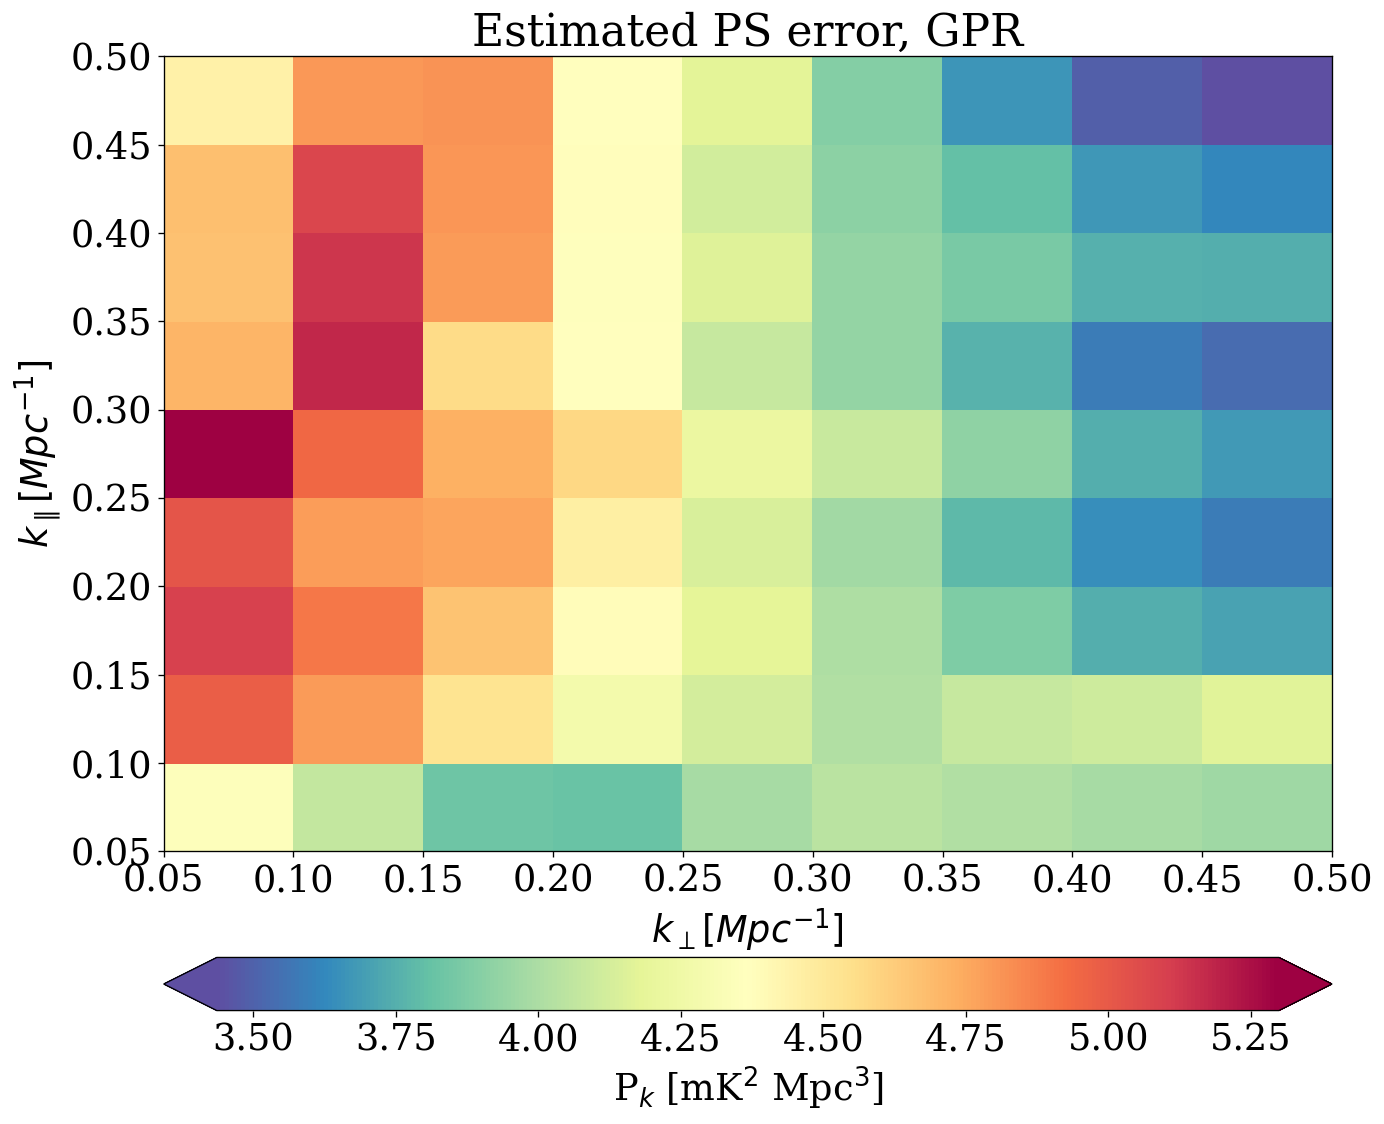

In [79]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=120)

im = ax.pcolormesh(kperp_bins, kpar_bins, np.log10(abs(ps_2D_Error*1e6)),cmap = 'Spectral_r')


cbar = fig.colorbar(im, ax=ax, extend='both',pad=0.1, orientation='horizontal')

cbar.ax.minorticks_off()

cbar.set_label(r'P$_{k}$ [mK$^{2}$ Mpc$^{3}$]')
#ax.set_xscale('log')
plt.title('Estimated PS error, GPR')
ax.set_xlabel(r'$k_{\perp} [Mpc^{-1}]$')
ax.set_ylabel(r'$k_{\parallel} [Mpc^{-1}]$')
plt.tight_layout()
plt.show()

 <ipython-input-80-f8f49b22152e>:3: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


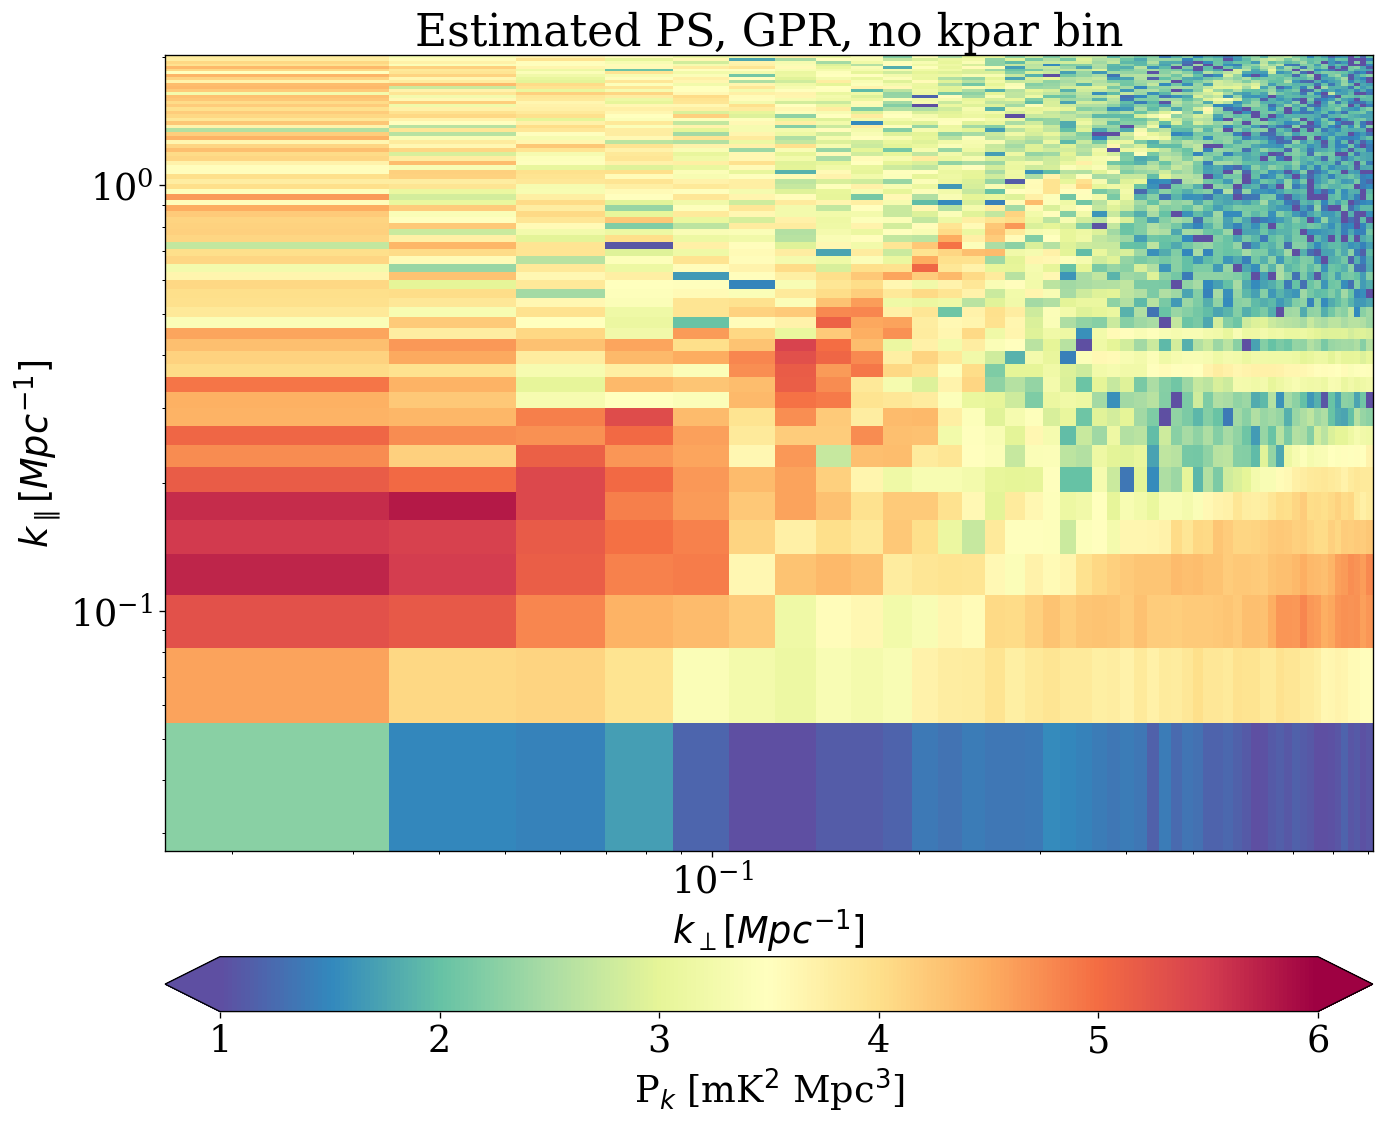

In [80]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=120)

im = ax.pcolormesh(k_perp, k_par, np.log10(abs(ps_2D_no_kpar*1e6)),vmin=1,vmax=6,cmap = 'Spectral_r')


cbar = fig.colorbar(im, ax=ax, extend='both',pad=0.1, orientation='horizontal')

cbar.ax.minorticks_off()

cbar.set_label(r'P$_{k}$ [mK$^{2}$ Mpc$^{3}$]')
ax.set_xscale('log')
ax.set_yscale('log')
plt.title('Estimated PS, GPR, no kpar bin')
ax.set_xlabel(r'$k_{\perp} [Mpc^{-1}]$')
ax.set_ylabel(r'$k_{\parallel} [Mpc^{-1}]$')
plt.tight_layout()
plt.show()

In [81]:
def k_to_delay(k, z, unit=un.Mpc):
    '''Convert delay to inverse co-moving distance in h Mpc^-1 '''
    return k * freqency_to_comoving_distance(z, unit=unit) / (2 * np.pi)

def freqency_to_comoving_distance(z, unit=un.Mpc):
    '''Return frequency to co-moving distance conversion factor'''
    return ((const.c * (1 + z) ** 2) / (cosmo.H(z) * f21)).to(unit * un.Hz ** -1).value 

def delay_to_k(delay, z, unit=un.Mpc):
    '''Convert delay to inverse co-moving distance in h Mpc^-1 '''
    return 2 * np.pi * delay / freqency_to_comoving_distance(z, unit=unit)


In [82]:
tau_horizon = k_to_delay(k_perp,redshift)
kpar_horizon_100ns_buffer = ps_tools.delay_to_kpara((tau_horizon+100e-9) * un.s,redshift).value
kpar_horizon = ps_tools.delay_to_kpara(tau_horizon * un.s,redshift).value


 <ipython-input-83-48921729d1d2>:3: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


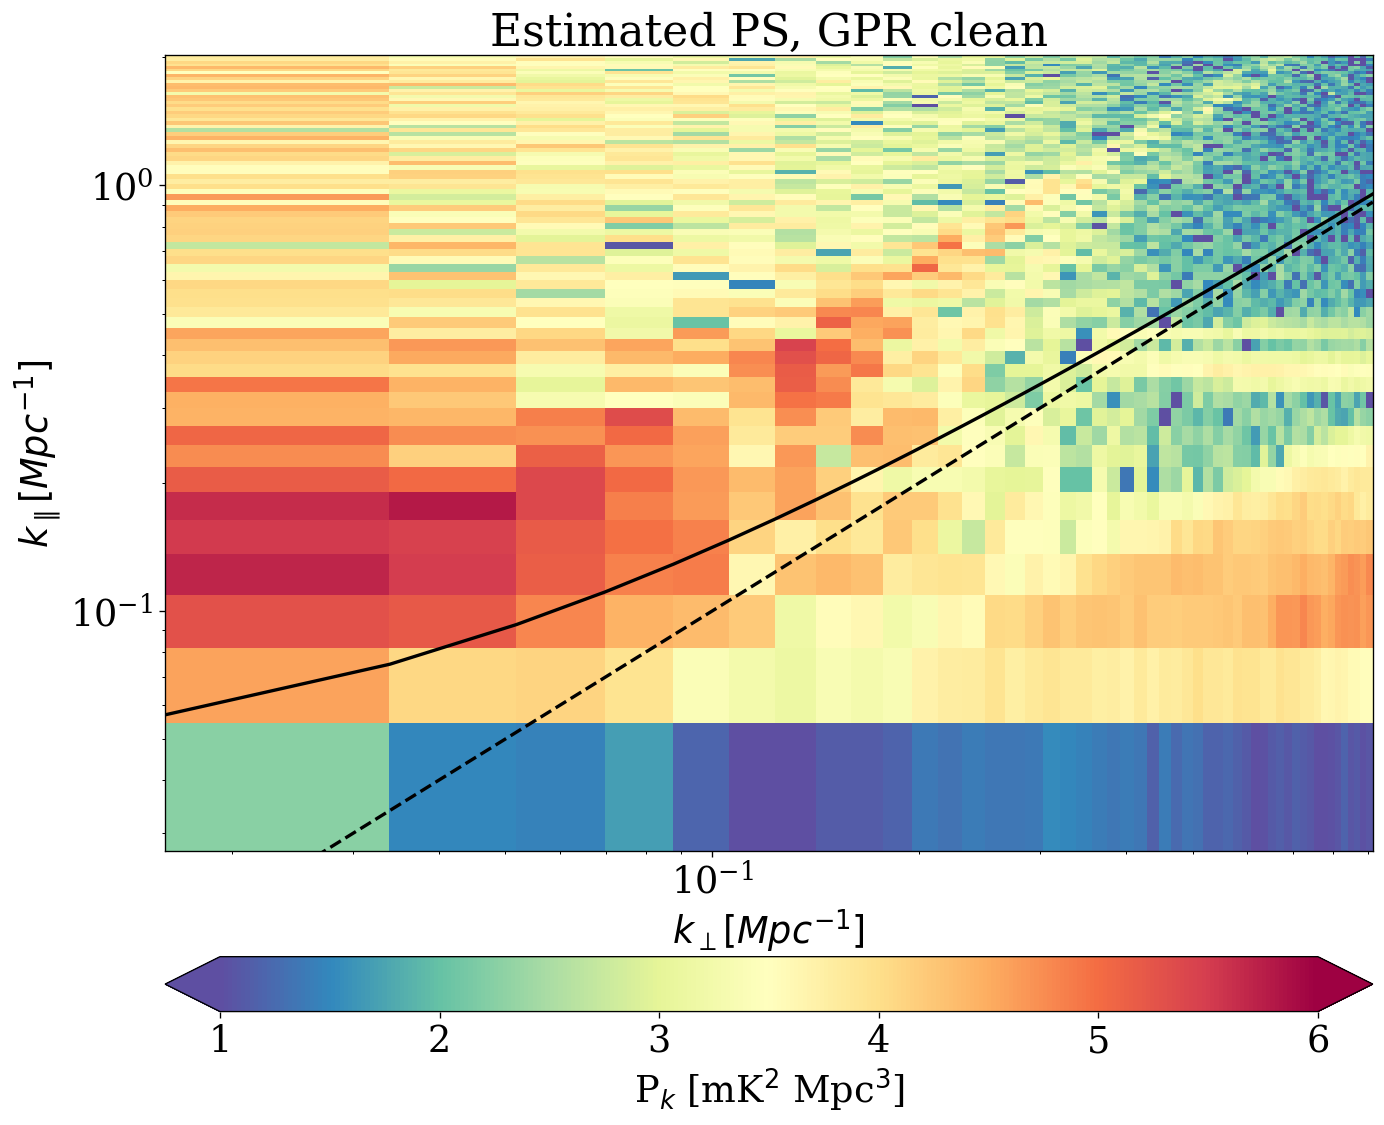

In [83]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=120)

im = ax.pcolormesh(k_perp, k_par, np.log10(abs(ps_2D_no_kpar*1e6)),vmin=1,vmax=6,cmap = 'Spectral_r')

plt.plot(k_perp,kpar_horizon_100ns_buffer,color='black',lw=2)
plt.plot(k_perp,kpar_horizon,color='black',lw=2,linestyle='--')

cbar = fig.colorbar(im, ax=ax, extend='both',pad=0.1, orientation='horizontal')

cbar.ax.minorticks_off()

cbar.set_label(r'P$_{k}$ [mK$^{2}$ Mpc$^{3}$]')
ax.set_xscale('log')
ax.set_yscale('log')
plt.title('Estimated PS, GPR clean')
ax.set_xlabel(r'$k_{\perp} [Mpc^{-1}]$')
ax.set_ylabel(r'$k_{\parallel} [Mpc^{-1}]$')
plt.ylim(k_par.min(),k_par.max())
plt.tight_layout()
plt.show()

In [84]:
# True ps 
ps = np.loadtxt(os.path.join("/project/def-mdobbs/arnab92/SKAD3/test_data","TestDatasetTRUTH_166MHz-181MHz.data"))

In [85]:
import matplotlib.gridspec as gridspec

 <ipython-input-86-9fd06450f382>:6: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
 <ipython-input-86-9fd06450f382>:14: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0.5, 1.0, 'True')

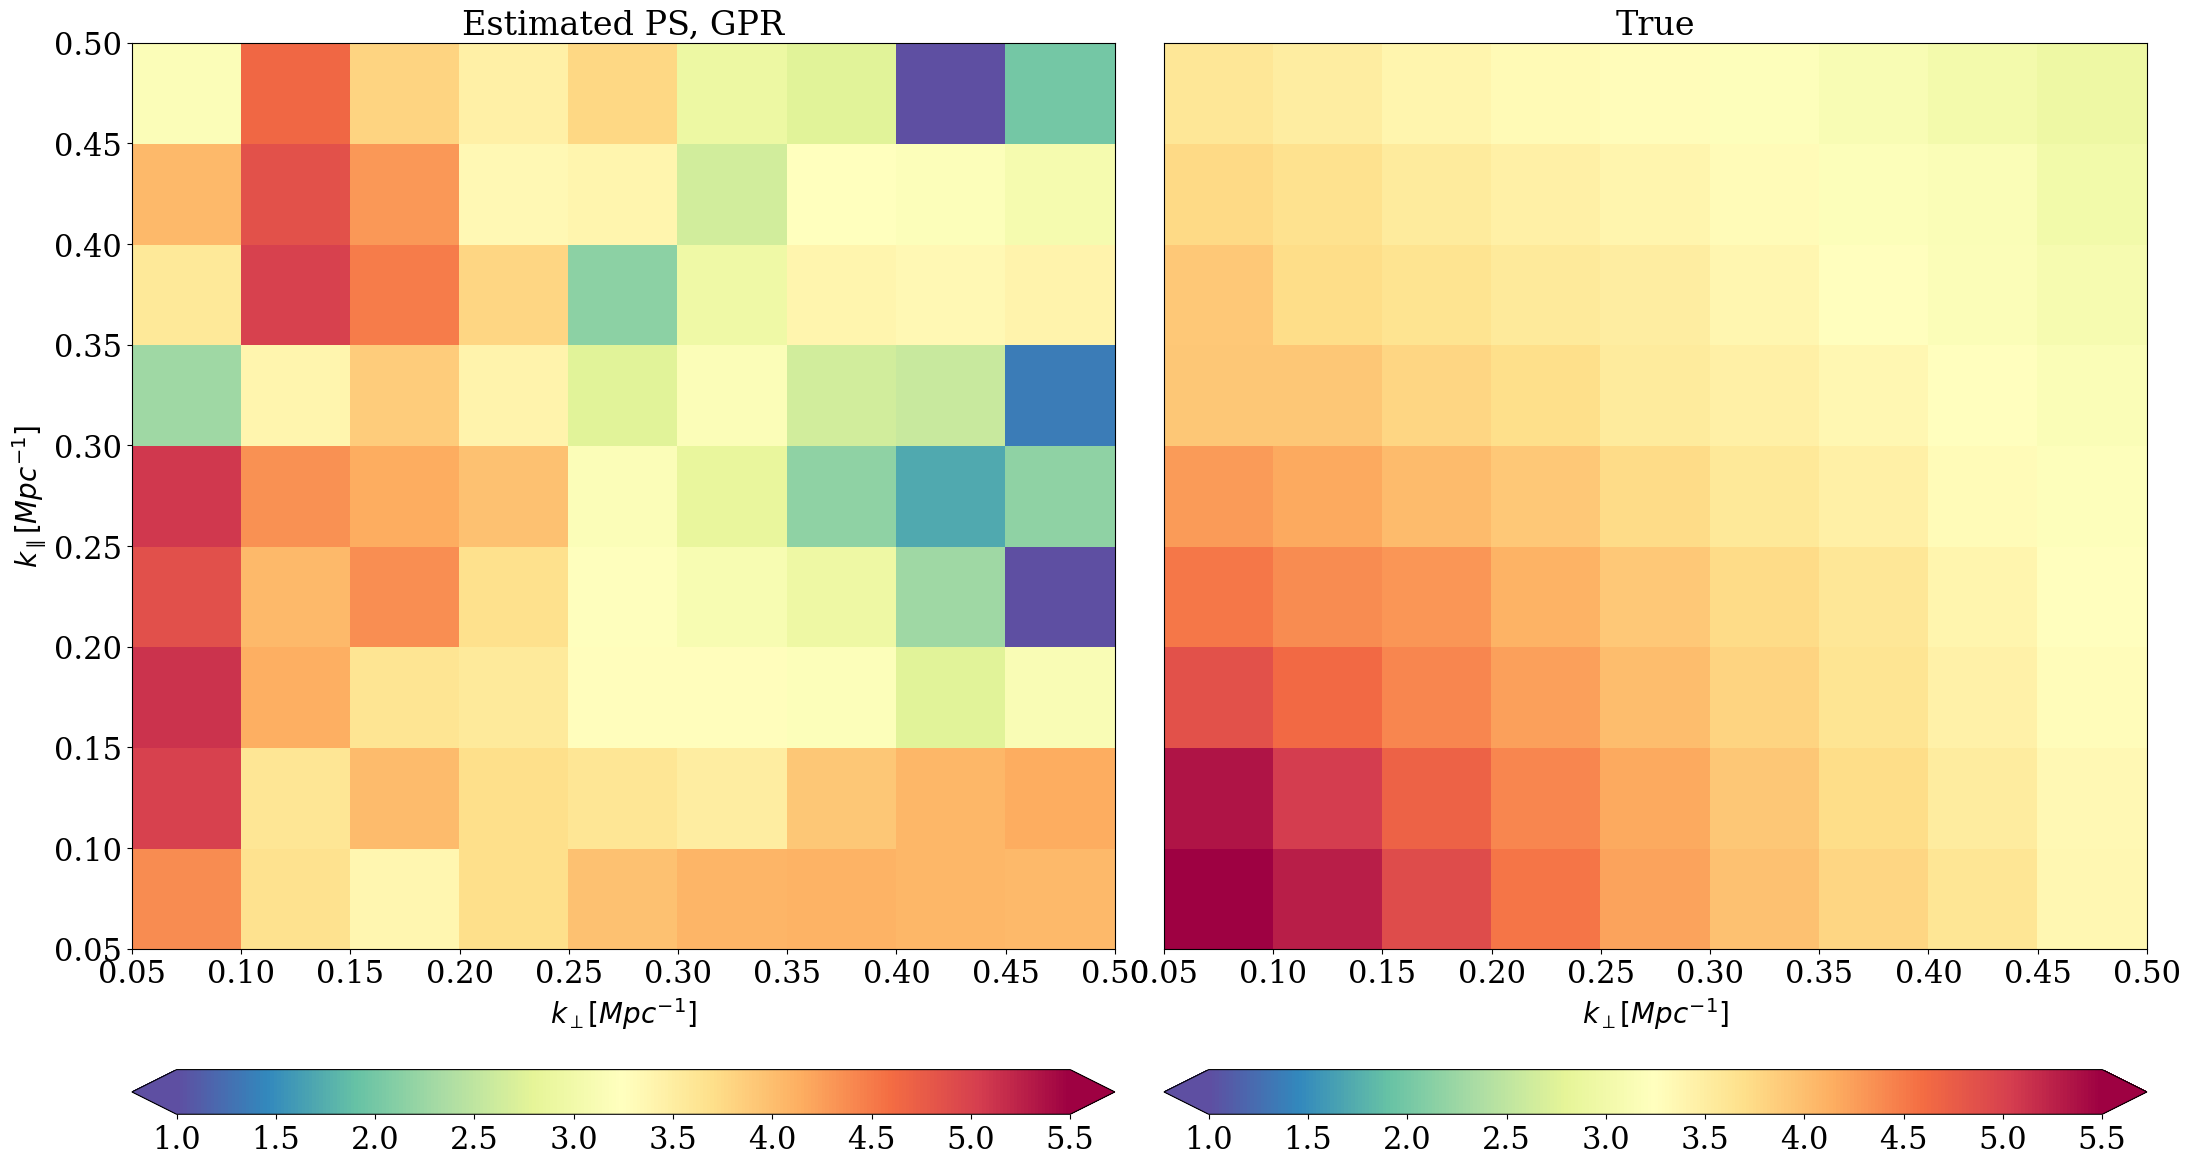

In [86]:
fig = plt.figure(num=1, figsize=(26, 16), dpi=100)

gspec = gridspec.GridSpec(1, 2, wspace=0.05)
  
plt.subplot(gspec[0, 0])
plt.pcolormesh(kperp_bins, kpar_bins, np.log10(abs(ps_2D*1e6)),vmin=1,vmax=5.5,cmap = 'Spectral_r')
plt.colorbar(extend='both',pad=0.1,orientation='horizontal')
plt.ylabel(r'$k_{\parallel} [Mpc^{-1}]$',fontsize=20)
plt.title(f'Estimated PS, GPR',fontsize=24)
plt.xlabel(r'$k_{\perp} [Mpc^{-1}]$',fontsize=20)


plt.subplot(gspec[0, 1])
plt.pcolormesh(kperp_bins, kpar_bins, np.log10((ps*1e6)),vmin=1,vmax=5.5,cmap = 'Spectral_r')
plt.colorbar(extend='both',pad=0.1,orientation='horizontal')
plt.yticks([])
plt.xlabel(r'$k_{\perp} [Mpc^{-1}]$',fontsize=20)
plt.title(f'True',fontsize=24)


# Calculate the transfer function, Following MErtens+2020 formalism, Appendix -A



In [87]:
path = '/project/def-mdobbs/arnab92/SKAD3/test_data'
data_u = os.path.join(path,'TestDataset.msn_image-003.fits')

In [88]:
# del image

In [89]:
hdu = fits.open(data_u)[0]
image_HI = np.array(hdu.data[1:,:,:])

In [90]:
image_HI.shape

(150, 2048, 2048)

In [91]:
# Do the PB correction by dividing the beam, Throwing the first freq channel
data_pb = np.divide(image_HI,pb_map)

In [92]:
# del gpr_HI

In [93]:
# Convert to kelvin
cart_map_kelvin_HI = data_pb[:, idx:-idx, idx:-idx] * jybeam2k_factor[:,None,None]

In [94]:
# HI auto ps 
_,_,ps_2D_HI,_,_,_,ps_2D_no_kpar_HI = powerspec_cross(data_cube_1 =cart_map_kelvin_HI,
                  data_cube_2 = cart_map_kelvin_HI,freq = freq,redshift=redshift,wl=wl,
                  chan_res = chan_res,pixel_res=dx,kperp_bins=kperp_bins,kpar_bins=kpar_bins,
                  apply_spectral_window = False,u_min=umin,u_max=umax,Nbins_2D=50,
                  log_bins=False)

Fourier Norm : 4.938271604938272e-06
Fourier Norm : 4.938271604938272e-06
Linear size in X-direction = 301.96045005087433 Mpc
Linear size in Y-direction = 301.96045005087433 Mpc
Linear size in Z-direction = 229.94323336733993 Mpc
Power Spectrum normalization factor  value - 20966250.092830118 Mpc^3
volume normalization = 20966250.092830118
correlate the vis cube 1 with vis cube 2
Min baseline: 35.0 m, Max baseline: 2000.0 m,z: 6.531313637327678, Wavelength:1.5895676458112407 m
Min bl in wavelength unit: 22.018565924030018,Max bl: 1258.2037670874295
Min kperp: 0.015992862281789075 1 / Mpc, Max kperp: 0.9138778446736614 1 / Mpc
Gridded data cube shape in kx and ky direction - (450, 450)
Cylindrical averaging of real PS
Using unit uniform weighting
(6048,)
Using unit uniform weighting
Using linear binning in k_perp between 0.015992862281789075 and 0.9138778446736614
(6048,)


In [95]:
# Injecting mock HI to the data cube, for Even and Odd 
data_HI_p0 = image_even + image_HI
data_HI_p1 = image_odd + image_HI

In [96]:
# Run GPR
t0 = time.time()
gpr_data_p0_M = ps_tools.gpr_fg_clean(data_HI_p0, freq_MHz,k_fg_sky= kern_fg,k_HI= kern_21, nPCA=NprePCA,
                          num_restarts=num_restarts,noise_data=None, heteroscedastic=heteroscedastic, 
                          zero_noise=zero_noise, invert=invert)
t1 = time.time()
print((t1-t0)/60.)

FG kernels length 3
The foreground kernels are   sum.               |      value  |     constraints      |  priors
  rbf.variance       |  5005000.0  |  10000.0,10000000.0  |        
  rbf.lengthscale    |       13.0  |       6.0,20.0       |        
  Mat52.variance     |       55.0  |      10.0,100.0      |        
  Mat52.lengthscale  |        6.0  |       4.0,8.0        |        
  Mat32.variance     |        1.0  |       0.1,5.0        |        
  Mat32.lengthscale  |        4.0  |       2.0,6.0        |        
1.6123027483622232


In [97]:
t0 = time.time()
gpr_data_p1_M = ps_tools.gpr_fg_clean(data_HI_p1, freq_MHz,k_fg_sky= kern_fg,k_HI= kern_21, nPCA=NprePCA,
                          num_restarts=num_restarts,noise_data=None, heteroscedastic=heteroscedastic, 
                          zero_noise=zero_noise, invert=invert)
t1 = time.time()
print((t1-t0)/60.)

FG kernels length 3
The foreground kernels are   sum.               |      value  |     constraints      |  priors
  rbf.variance       |  5005000.0  |  10000.0,10000000.0  |        
  rbf.lengthscale    |       13.0  |       6.0,20.0       |        
  Mat52.variance     |       55.0  |      10.0,100.0      |        
  Mat52.lengthscale  |        6.0  |       4.0,8.0        |        
  Mat32.variance     |        1.0  |       0.1,5.0        |        
  Mat32.lengthscale  |        4.0  |       2.0,6.0        |        
1.7903465270996093


In [98]:
data_gpr_p0_HI = gpr_data_p0_M.res
data_gpr_p1_HI = gpr_data_p1_M.res

In [99]:
del gpr_data_p0_M, gpr_data_p1_M

In [100]:
# Subtracting GPR on data from GPR on data+Mock
M_p0 = data_gpr_p0_HI - gpr_res_cube_even
M_p1 = data_gpr_p1_HI - gpr_res_cube_odd

In [101]:
# Do the PB correction by dividing the beam, Throwing the first freq channel
M_p0_pb = np.divide(M_p0,pb_map)
M_p1_pb = np.divide(M_p1,pb_map)

In [102]:
# Taking the central 2 deg 
cart_map_M_p0 = M_p0_pb[:, idx:-idx, idx:-idx] * jybeam2k_factor[:,None,None]
cart_map_M_p1 = M_p1_pb[:, idx:-idx, idx:-idx] * jybeam2k_factor[:,None,None]

In [103]:
# corss ps, with mock HI subtraction 
_,_,ps_2D_M,_,_,_,ps_2D_no_kpar_M = powerspec_cross(data_cube_1 =cart_map_M_p0,
                  data_cube_2 = cart_map_M_p1,freq = freq,redshift=redshift,wl=wl,
                  chan_res = chan_res,pixel_res=dx,kperp_bins=kperp_bins,kpar_bins=kpar_bins,
                  apply_spectral_window = False,u_min=umin,u_max=umax,Nbins_2D=50,
                  log_bins=False)

Fourier Norm : 4.938271604938272e-06
Fourier Norm : 4.938271604938272e-06
Linear size in X-direction = 301.96045005087433 Mpc
Linear size in Y-direction = 301.96045005087433 Mpc
Linear size in Z-direction = 229.94323336733993 Mpc
Power Spectrum normalization factor  value - 20966250.092830118 Mpc^3
volume normalization = 20966250.092830118
correlate the vis cube 1 with vis cube 2
Min baseline: 35.0 m, Max baseline: 2000.0 m,z: 6.531313637327678, Wavelength:1.5895676458112407 m
Min bl in wavelength unit: 22.018565924030018,Max bl: 1258.2037670874295
Min kperp: 0.015992862281789075 1 / Mpc, Max kperp: 0.9138778446736614 1 / Mpc
Gridded data cube shape in kx and ky direction - (450, 450)
Cylindrical averaging of real PS
Using unit uniform weighting
(6048,)
Using unit uniform weighting
Using linear binning in k_perp between 0.015992862281789075 and 0.9138778446736614
(6048,)


 <ipython-input-104-c3339a0caac0>:6: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
 <ipython-input-104-c3339a0caac0>:14: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0.5, 1.0, 'True')

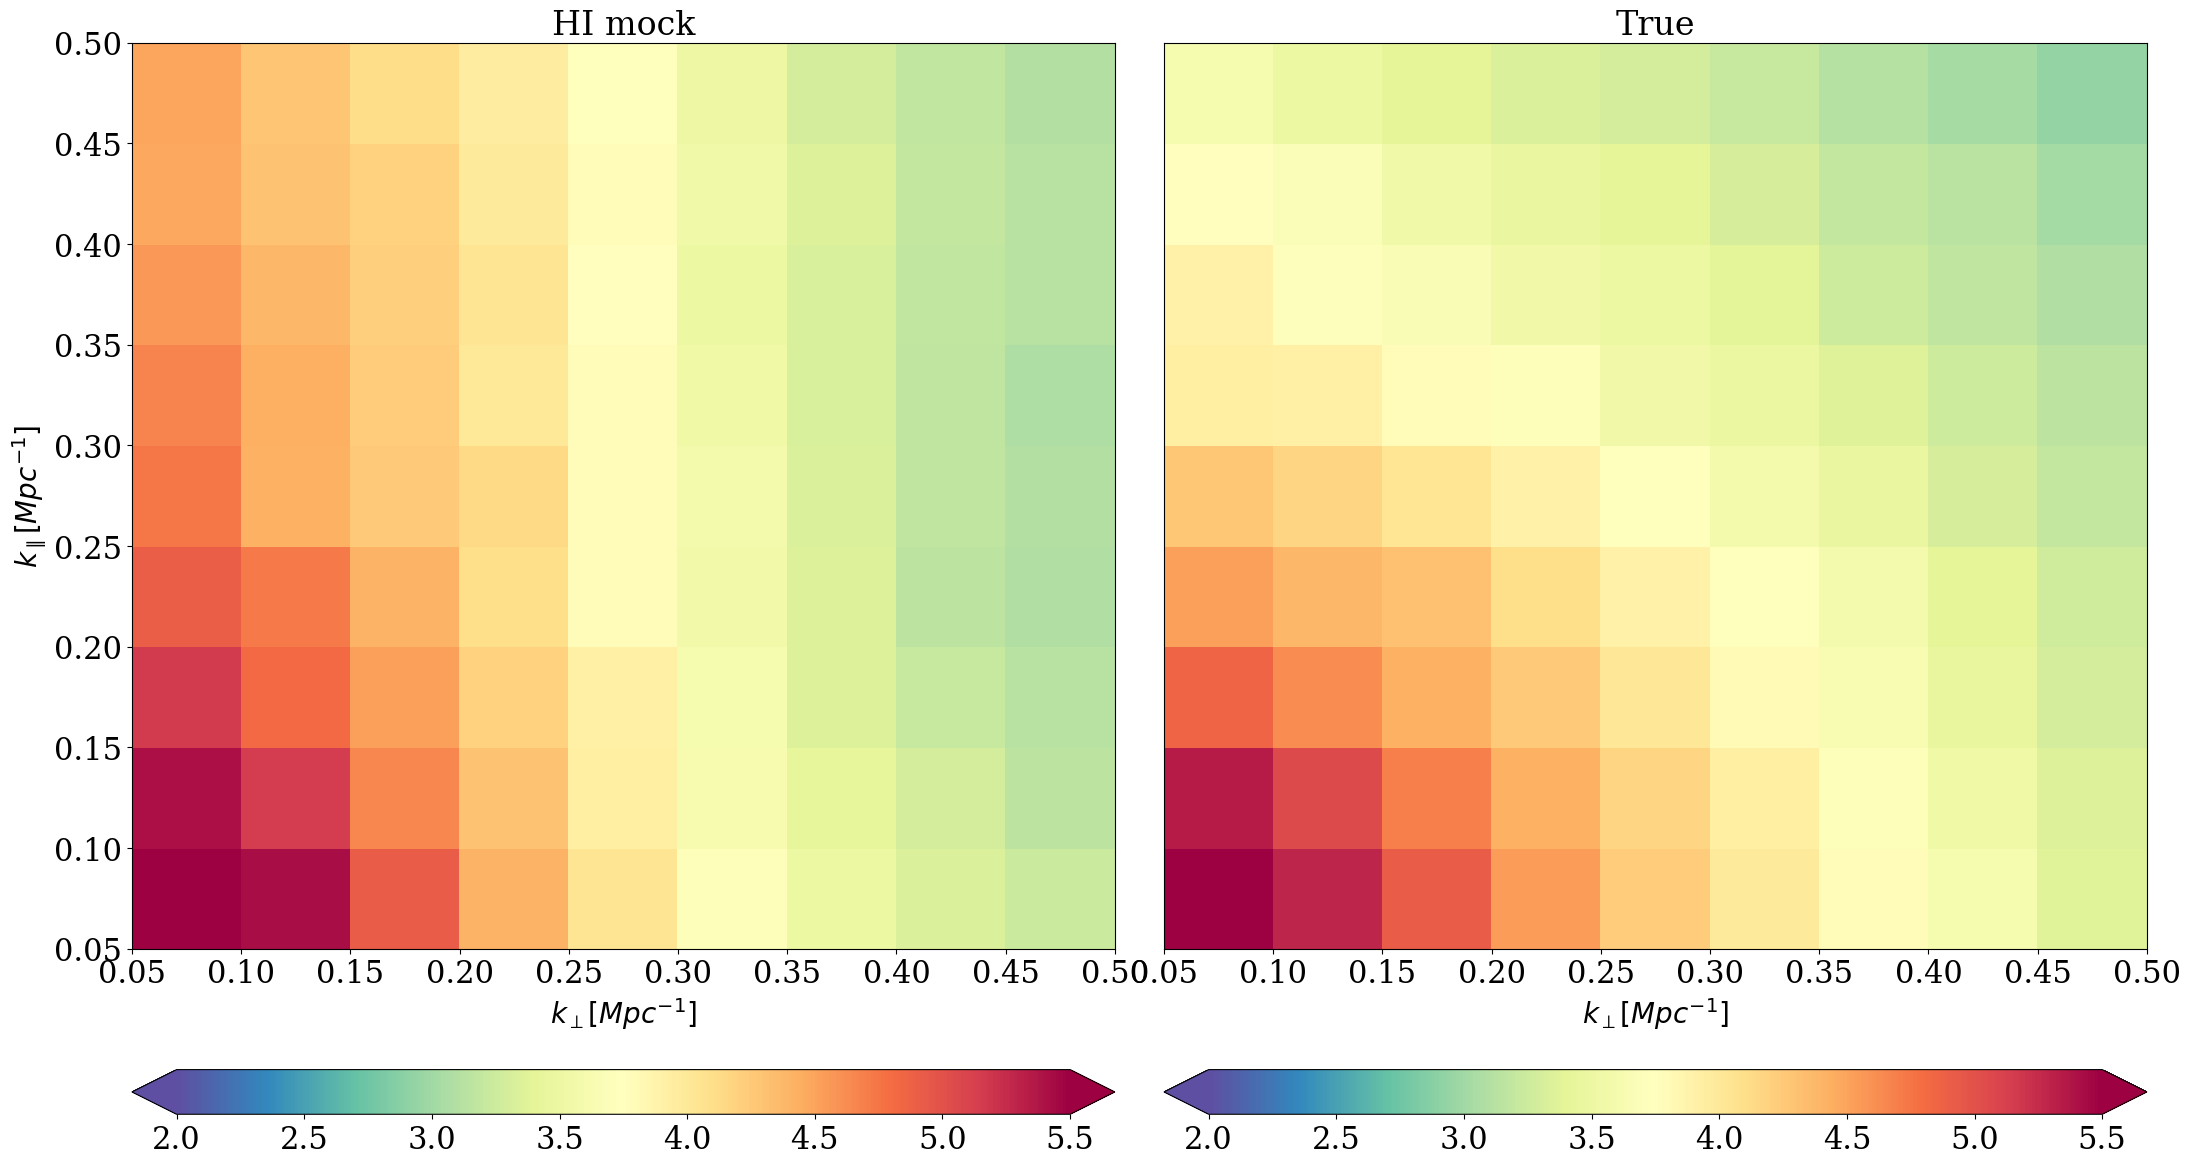

In [104]:
fig = plt.figure(num=1, figsize=(26, 16), dpi=100)

gspec = gridspec.GridSpec(1, 2, wspace=0.05)
  
plt.subplot(gspec[0, 0])
plt.pcolormesh(kperp_bins, kpar_bins, np.log10((ps_2D_HI*1e6)),vmin=2,vmax=5.5,cmap = 'Spectral_r')
plt.colorbar(extend='both',pad=0.1,orientation='horizontal')
plt.ylabel(r'$k_{\parallel} [Mpc^{-1}]$',fontsize=20)
plt.title(f'HI mock',fontsize=24)
plt.xlabel(r'$k_{\perp} [Mpc^{-1}]$',fontsize=20)


plt.subplot(gspec[0, 1])
plt.pcolormesh(kperp_bins, kpar_bins, np.log10((ps*1e6)),vmin=2,vmax=5.5,cmap = 'Spectral_r')
plt.colorbar(extend='both',pad=0.1,orientation='horizontal')
plt.yticks([])
plt.xlabel(r'$k_{\perp} [Mpc^{-1}]$',fontsize=20)
plt.title(f'True',fontsize=24)


In [105]:
# EStimate the Transfer function
T_k2D =  ps_2D_M/ ps_2D_HI
T_k2D_no_kpar =  ps_2D_no_kpar_M/ ps_2D_no_kpar_HI

 <ipython-input-106-70db19195cd7>:3: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


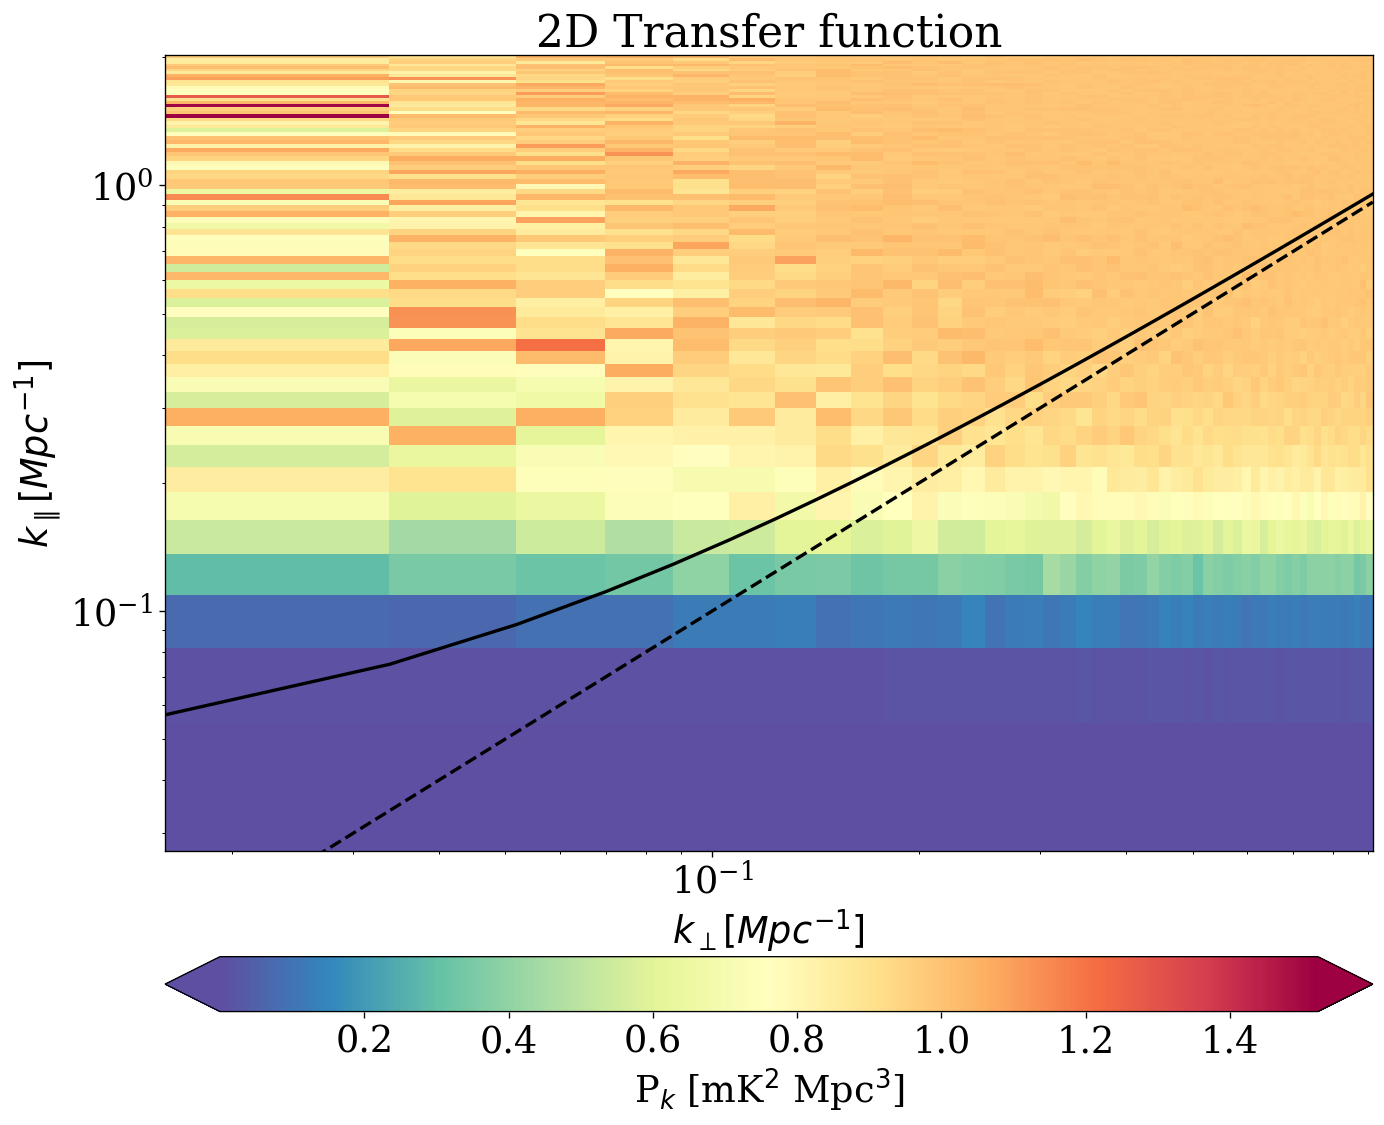

In [106]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=120)

im = ax.pcolormesh(k_perp, k_par, abs(T_k2D_no_kpar),cmap = 'Spectral_r')

plt.plot(k_perp,kpar_horizon_100ns_buffer,color='black',lw=2)
plt.plot(k_perp,kpar_horizon,color='black',lw=2,linestyle='--')

cbar = fig.colorbar(im, ax=ax, extend='both',pad=0.1, orientation='horizontal')

cbar.ax.minorticks_off()

cbar.set_label(r'P$_{k}$ [mK$^{2}$ Mpc$^{3}$]')
ax.set_xscale('log')
ax.set_yscale('log')
plt.title('2D Transfer function')
ax.set_xlabel(r'$k_{\perp} [Mpc^{-1}]$')
ax.set_ylabel(r'$k_{\parallel} [Mpc^{-1}]$')
plt.ylim(k_par.min(),k_par.max())
plt.tight_layout()
plt.show()

 <ipython-input-107-f5a093f09367>:3: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


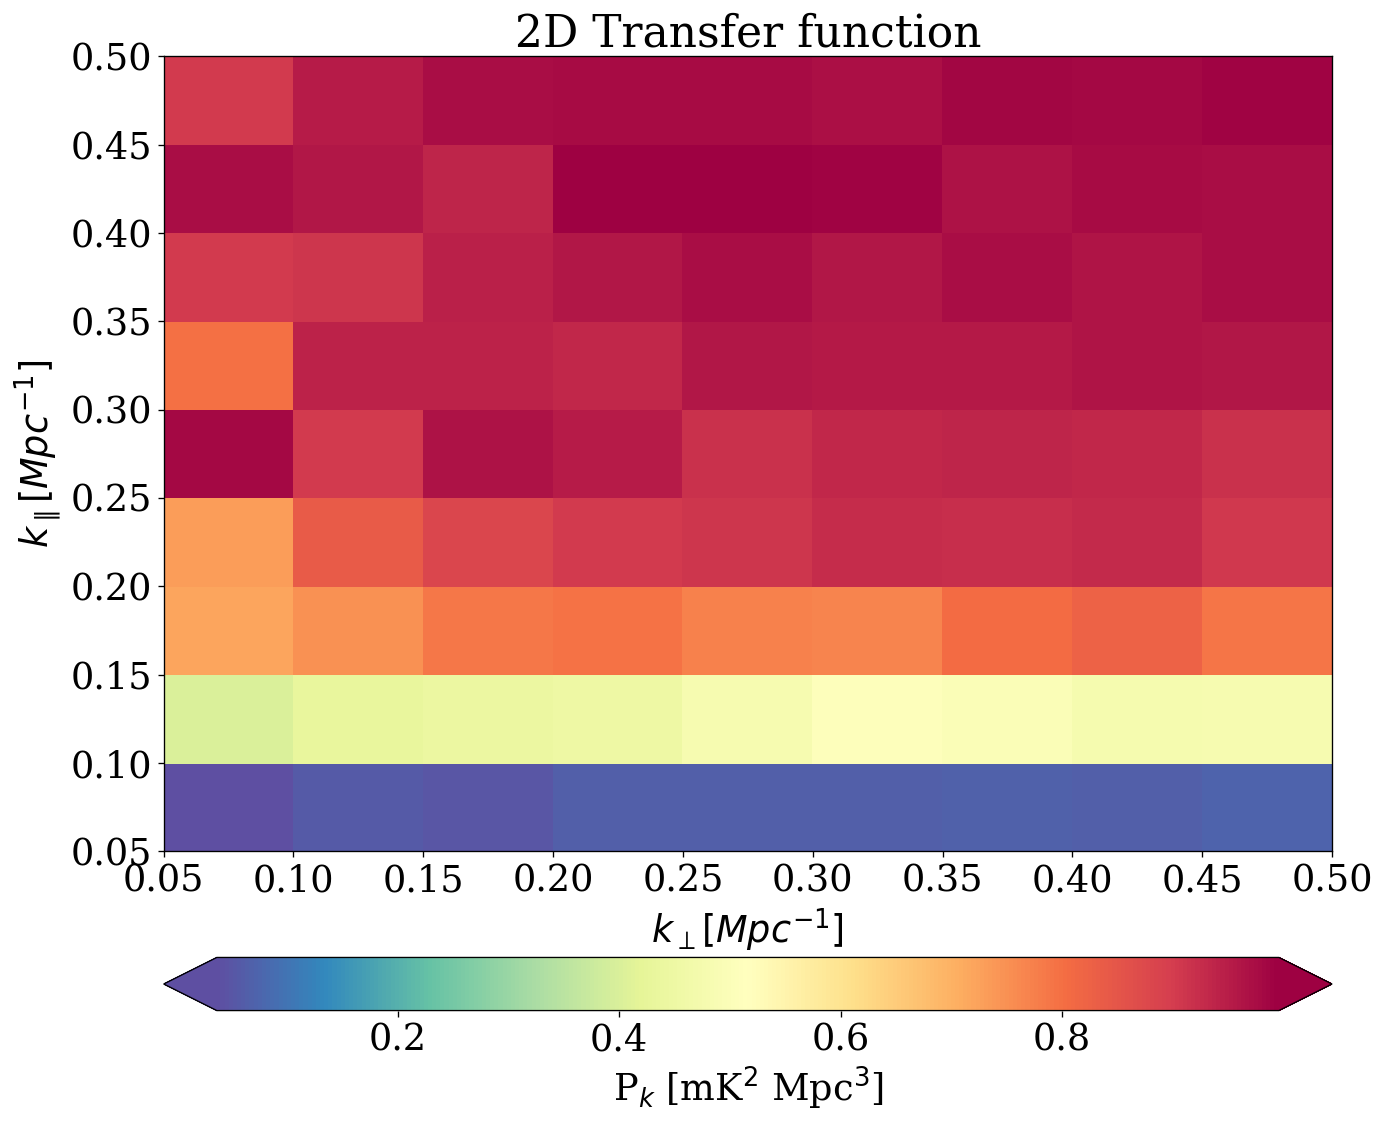

In [107]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=120)

im = ax.pcolormesh(kperp_bins, kpar_bins, abs(T_k2D),cmap = 'Spectral_r')


cbar = fig.colorbar(im, ax=ax, extend='both',pad=0.1, orientation='horizontal')

cbar.ax.minorticks_off()

cbar.set_label(r'P$_{k}$ [mK$^{2}$ Mpc$^{3}$]')
#ax.set_xscale('log')
plt.title('2D Transfer function')
ax.set_xlabel(r'$k_{\perp} [Mpc^{-1}]$')
ax.set_ylabel(r'$k_{\parallel} [Mpc^{-1}]$')
plt.tight_layout()
plt.show()

In [108]:
# Correct for Transfer function
ps_2D_corrected = abs(ps_2D) / abs(T_k2D)

 <ipython-input-109-ae86f0176def>:6: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
 <ipython-input-109-ae86f0176def>:14: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0.5, 1.0, 'Test HI (True)')

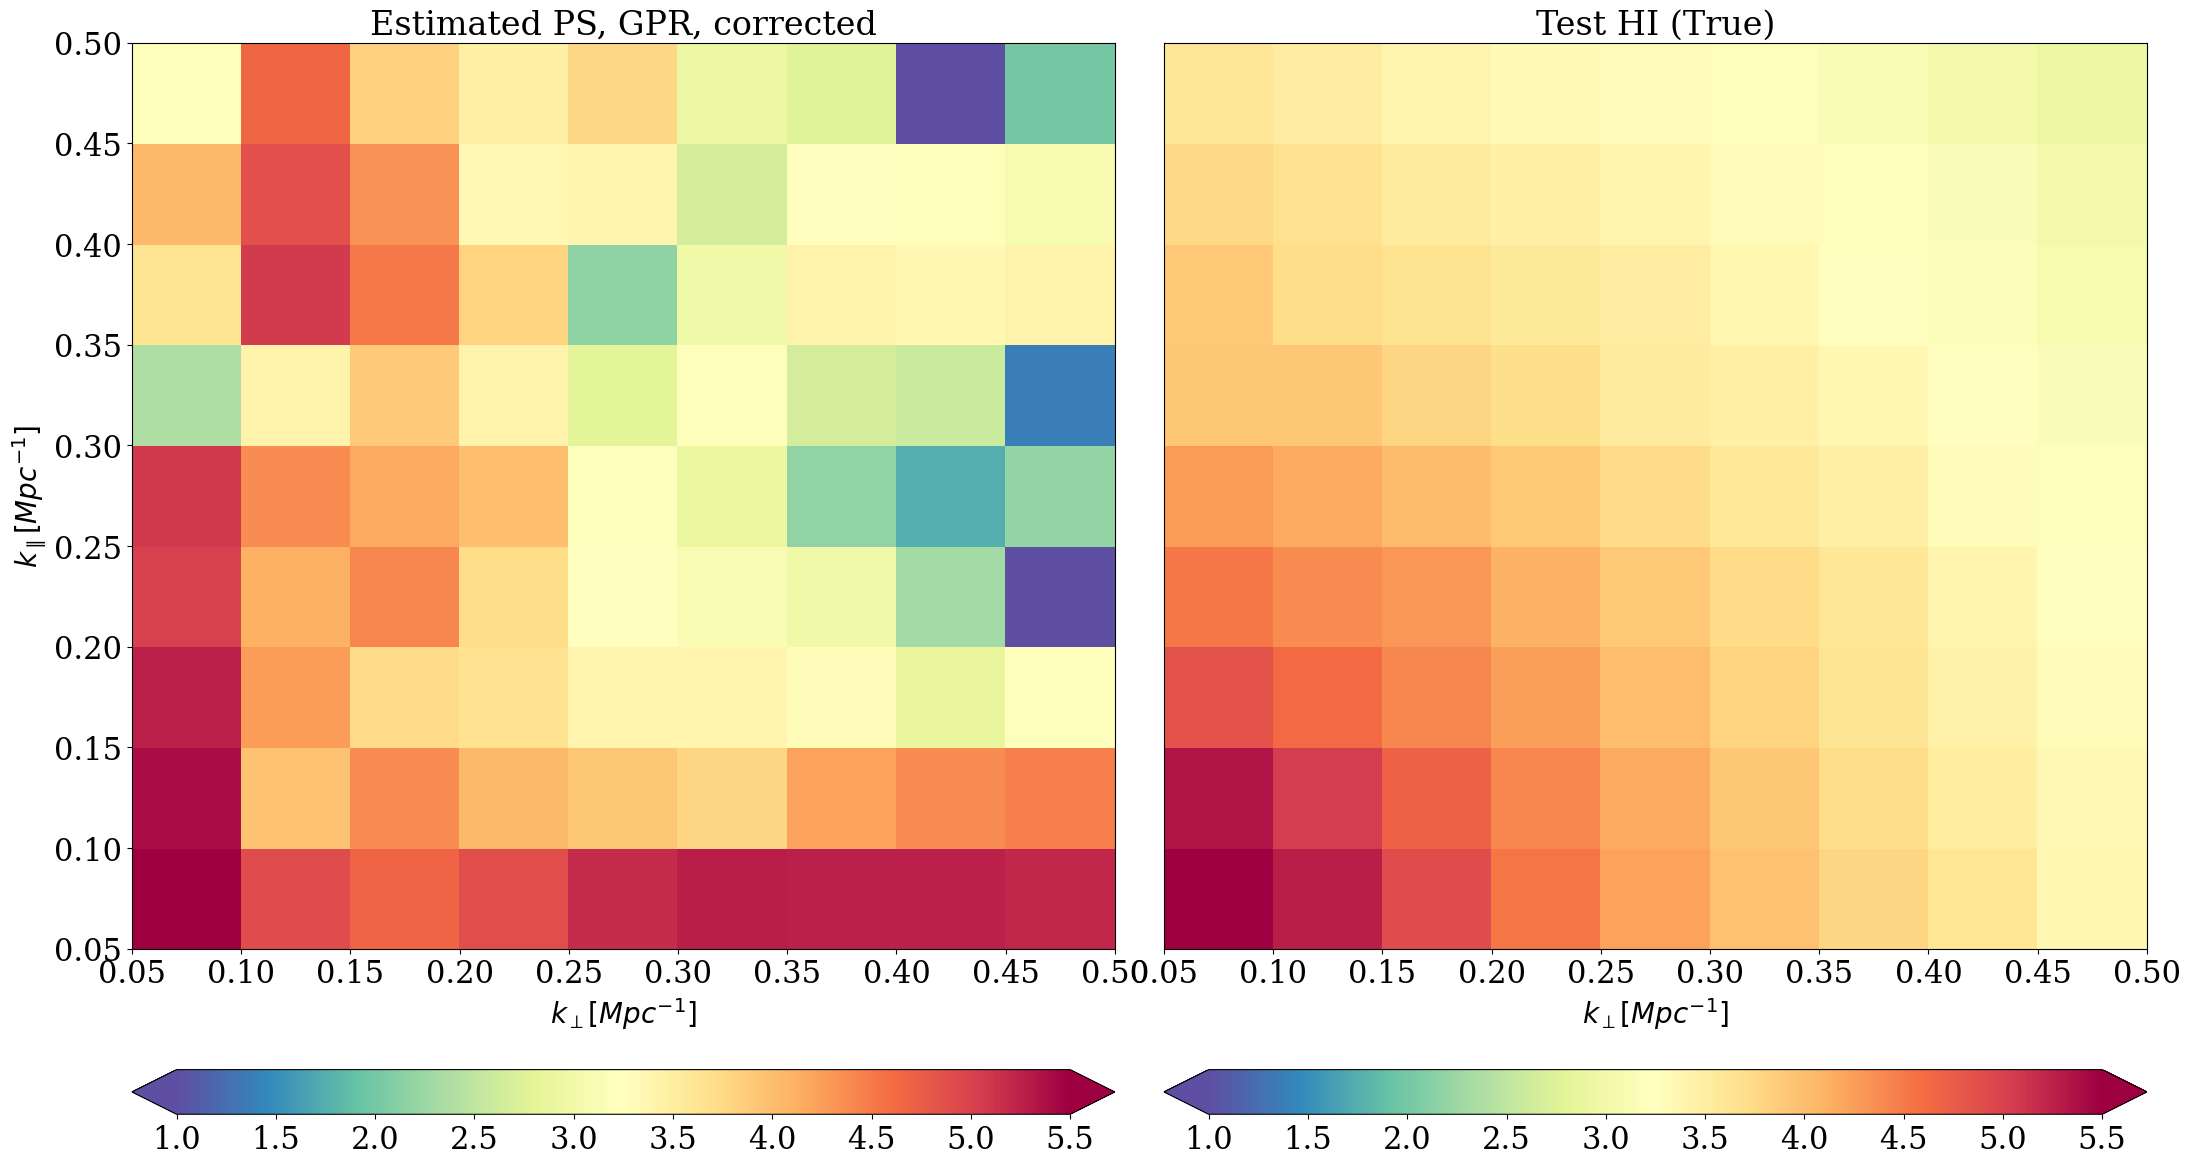

In [109]:
fig = plt.figure(num=1, figsize=(26, 16), dpi=100)

gspec = gridspec.GridSpec(1, 2, wspace=0.05)
  
plt.subplot(gspec[0, 0])
plt.pcolormesh(kperp_bins, kpar_bins, np.log10(abs(ps_2D_corrected*1e6)),vmin=1,vmax=5.5,cmap = 'Spectral_r')
plt.colorbar(extend='both',pad=0.1,orientation='horizontal')
plt.ylabel(r'$k_{\parallel} [Mpc^{-1}]$',fontsize=20)
plt.title(f'Estimated PS, GPR, corrected',fontsize=24)
plt.xlabel(r'$k_{\perp} [Mpc^{-1}]$',fontsize=20)


plt.subplot(gspec[0, 1])
plt.pcolormesh(kperp_bins, kpar_bins, np.log10((ps*1e6)),vmin=1,vmax=5.5,cmap = 'Spectral_r')
plt.colorbar(extend='both',pad=0.1,orientation='horizontal')
plt.yticks([])
plt.xlabel(r'$k_{\perp} [Mpc^{-1}]$',fontsize=20)
plt.title(f'Test HI (True)',fontsize=24)


 <ipython-input-110-6844671631b3>:6: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
 <ipython-input-110-6844671631b3>:14: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0.5, 1.0, 'Estimated PS, GPR,')

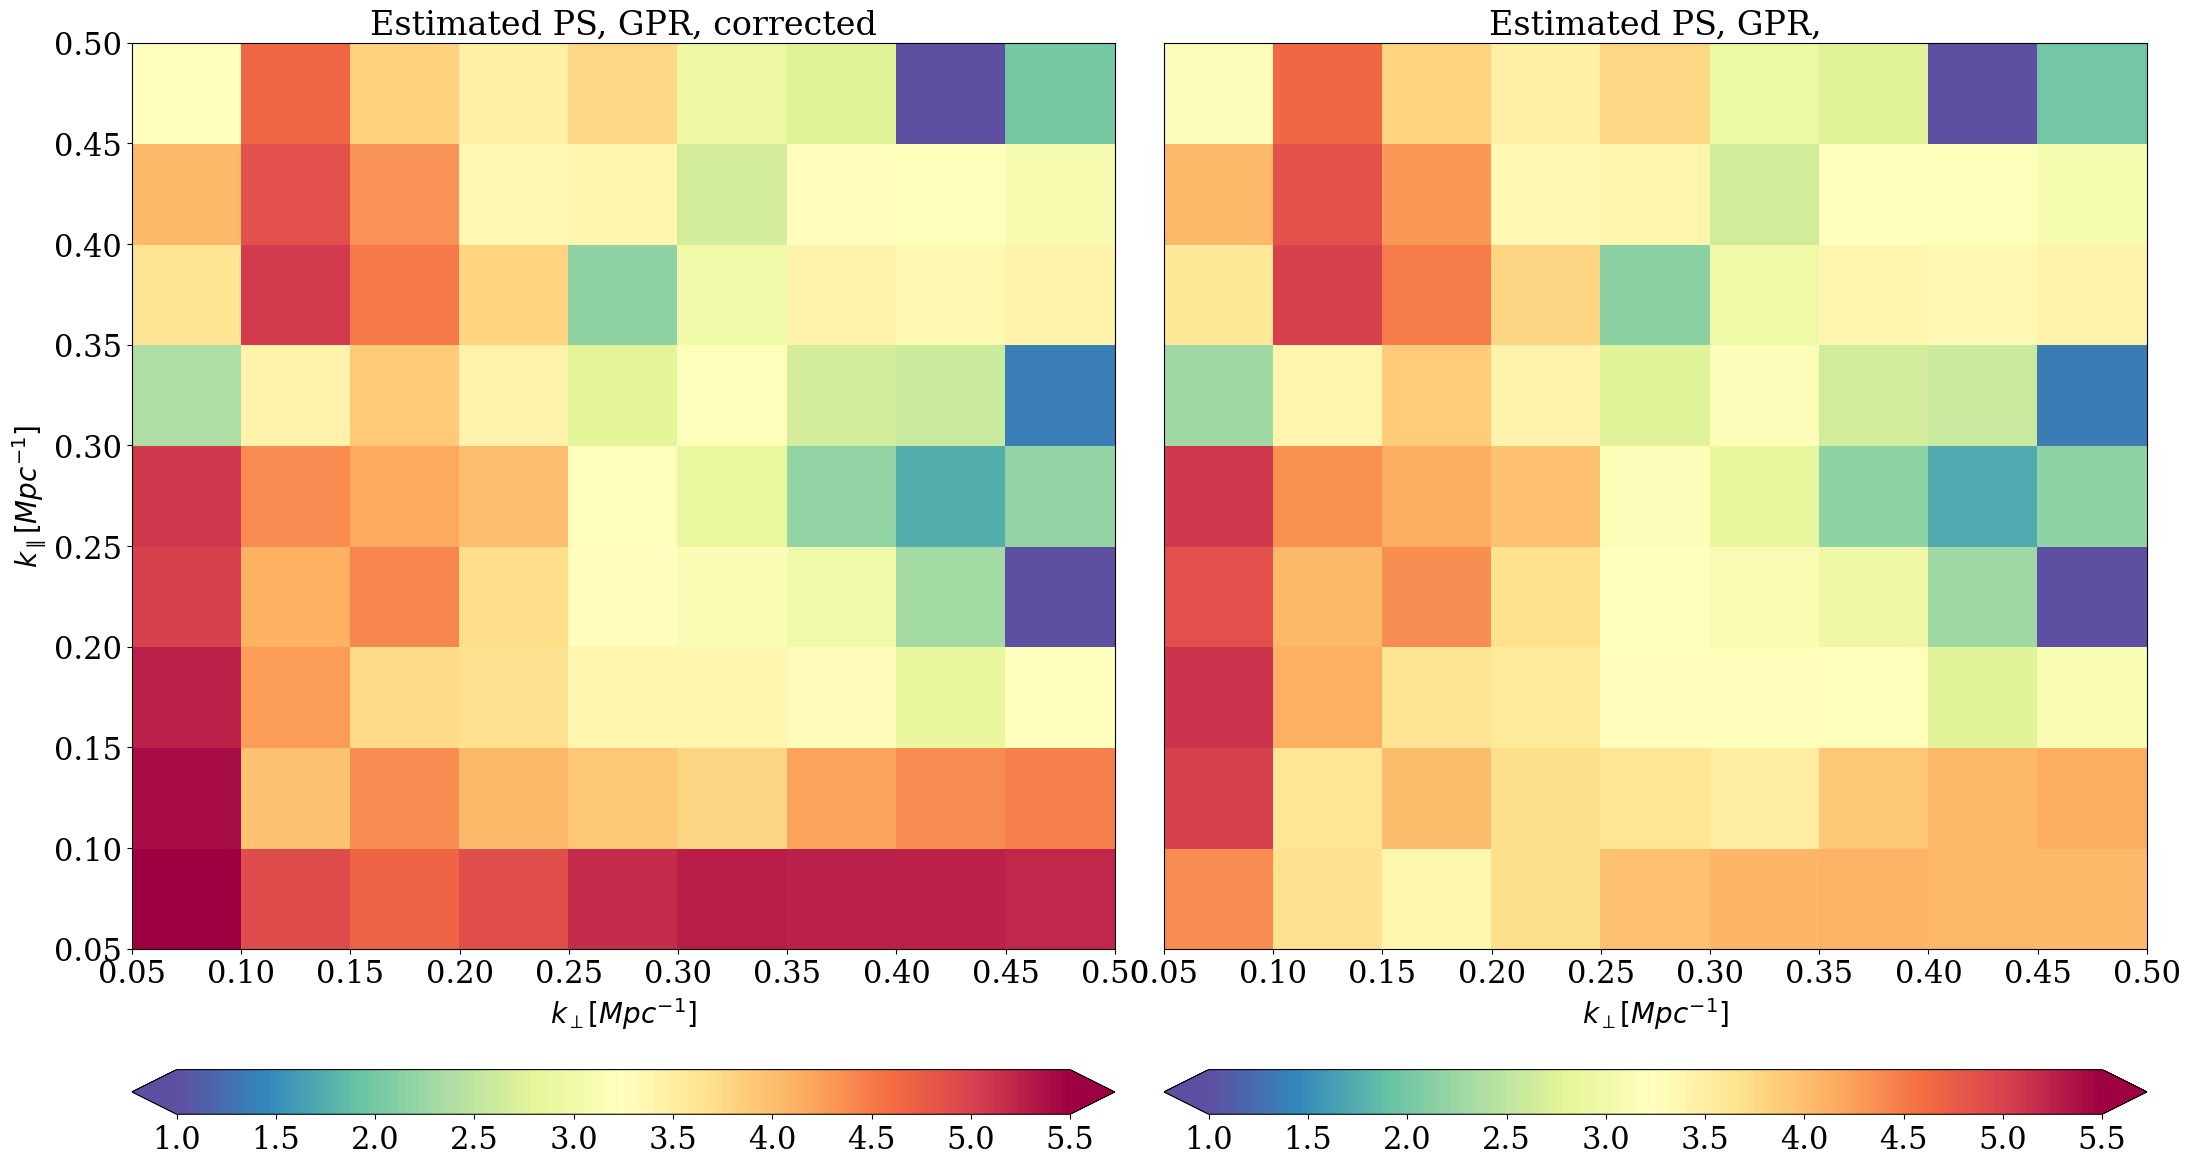

In [110]:
fig = plt.figure(num=1, figsize=(26, 16), dpi=100)

gspec = gridspec.GridSpec(1, 2, wspace=0.05)
  
plt.subplot(gspec[0, 0])
plt.pcolormesh(kperp_bins, kpar_bins, np.log10(abs(ps_2D_corrected*1e6)),vmin=1,vmax=5.5,cmap = 'Spectral_r')
plt.colorbar(extend='both',pad=0.1,orientation='horizontal')
plt.ylabel(r'$k_{\parallel} [Mpc^{-1}]$',fontsize=20)
plt.title(f'Estimated PS, GPR, corrected',fontsize=24)
plt.xlabel(r'$k_{\perp} [Mpc^{-1}]$',fontsize=20)


plt.subplot(gspec[0, 1])
plt.pcolormesh(kperp_bins, kpar_bins, np.log10(abs(ps_2D*1e6)),vmin=1,vmax=5.5,cmap = 'Spectral_r')
plt.colorbar(extend='both',pad=0.1,orientation='horizontal')
plt.yticks([])
plt.xlabel(r'$k_{\perp} [Mpc^{-1}]$',fontsize=20)
plt.title(f'Estimated PS, GPR,',fontsize=24)

In [111]:
ps_2D_error_corrected = abs(ps_2D_Error) / abs(T_k2D)

 <ipython-input-112-8e2477a7ccbf>:3: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


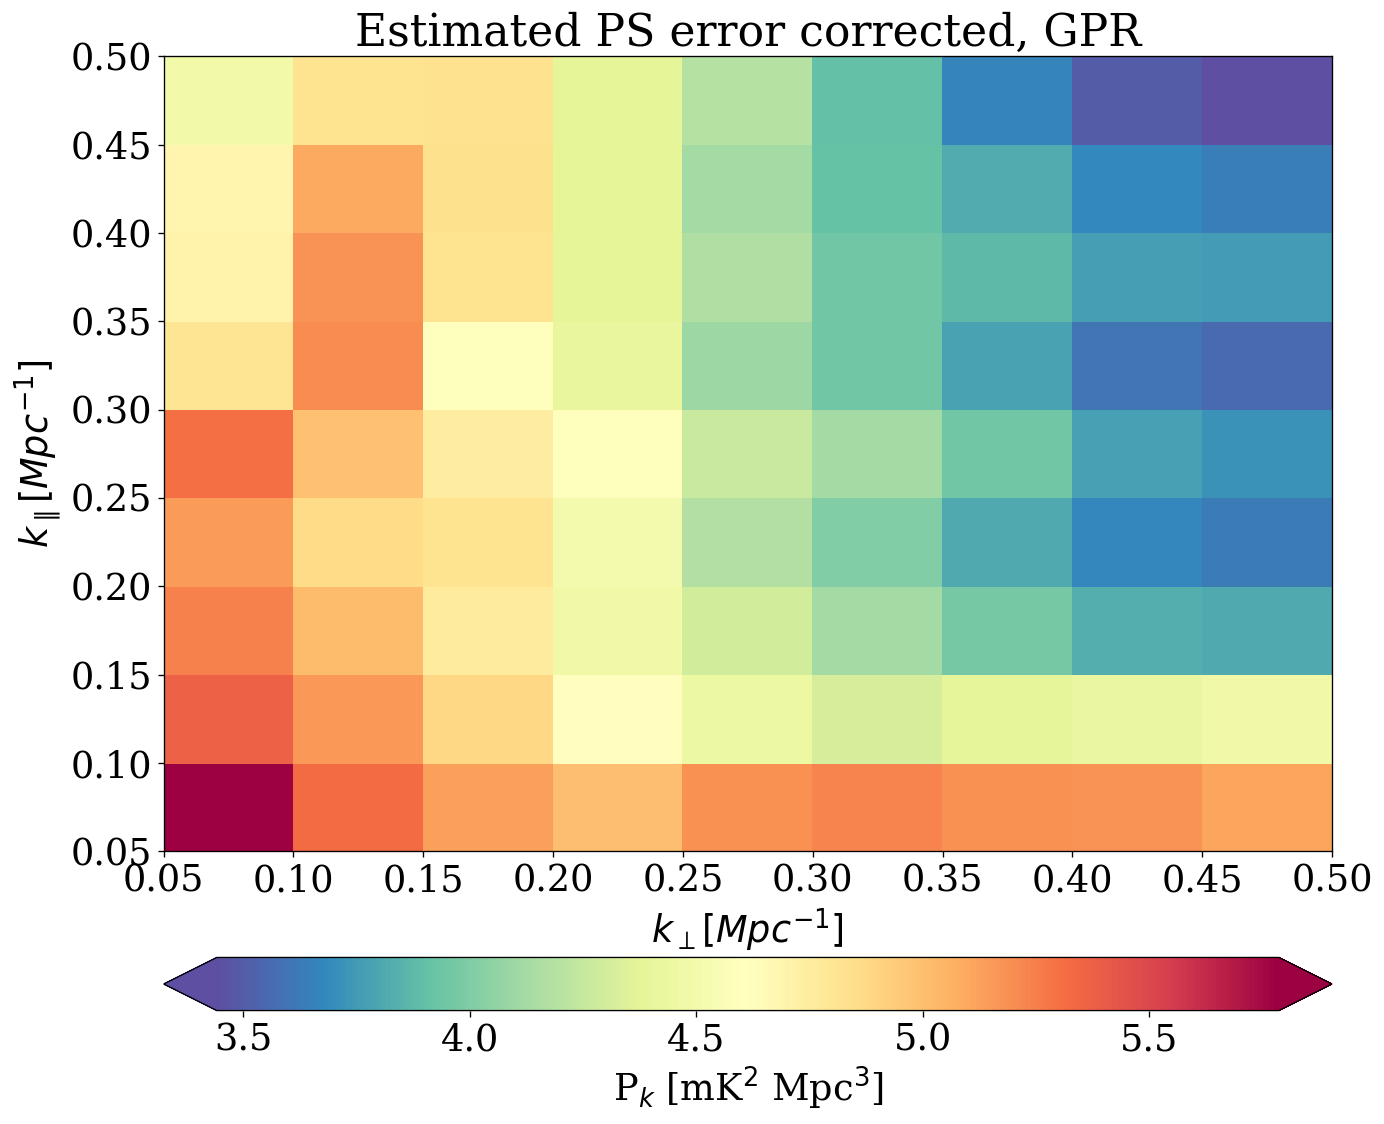

In [112]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=120)

im = ax.pcolormesh(kperp_bins, kpar_bins, np.log10(abs(ps_2D_error_corrected*1e6)),cmap = 'Spectral_r')


cbar = fig.colorbar(im, ax=ax, extend='both',pad=0.1, orientation='horizontal')

cbar.ax.minorticks_off()

cbar.set_label(r'P$_{k}$ [mK$^{2}$ Mpc$^{3}$]')
#ax.set_xscale('log')
plt.title('Estimated PS error corrected, GPR')
ax.set_xlabel(r'$k_{\perp} [Mpc^{-1}]$')
ax.set_ylabel(r'$k_{\parallel} [Mpc^{-1}]$')
plt.tight_layout()
plt.show()

In [113]:
filename = 'Akashganga_181MHz_196MHz.data'
np.savetxt(filename,abs(ps_2D_corrected))

In [114]:
filename_err = 'Akashganga_181MHz_196MHz_errors.data'
np.savetxt(filename_err,abs(ps_2D_error_corrected))

In [115]:
ps_measured = np.loadtxt('Akashganga_181MHz_196MHz.data')

 <ipython-input-116-ebea48a82bf6>:3: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


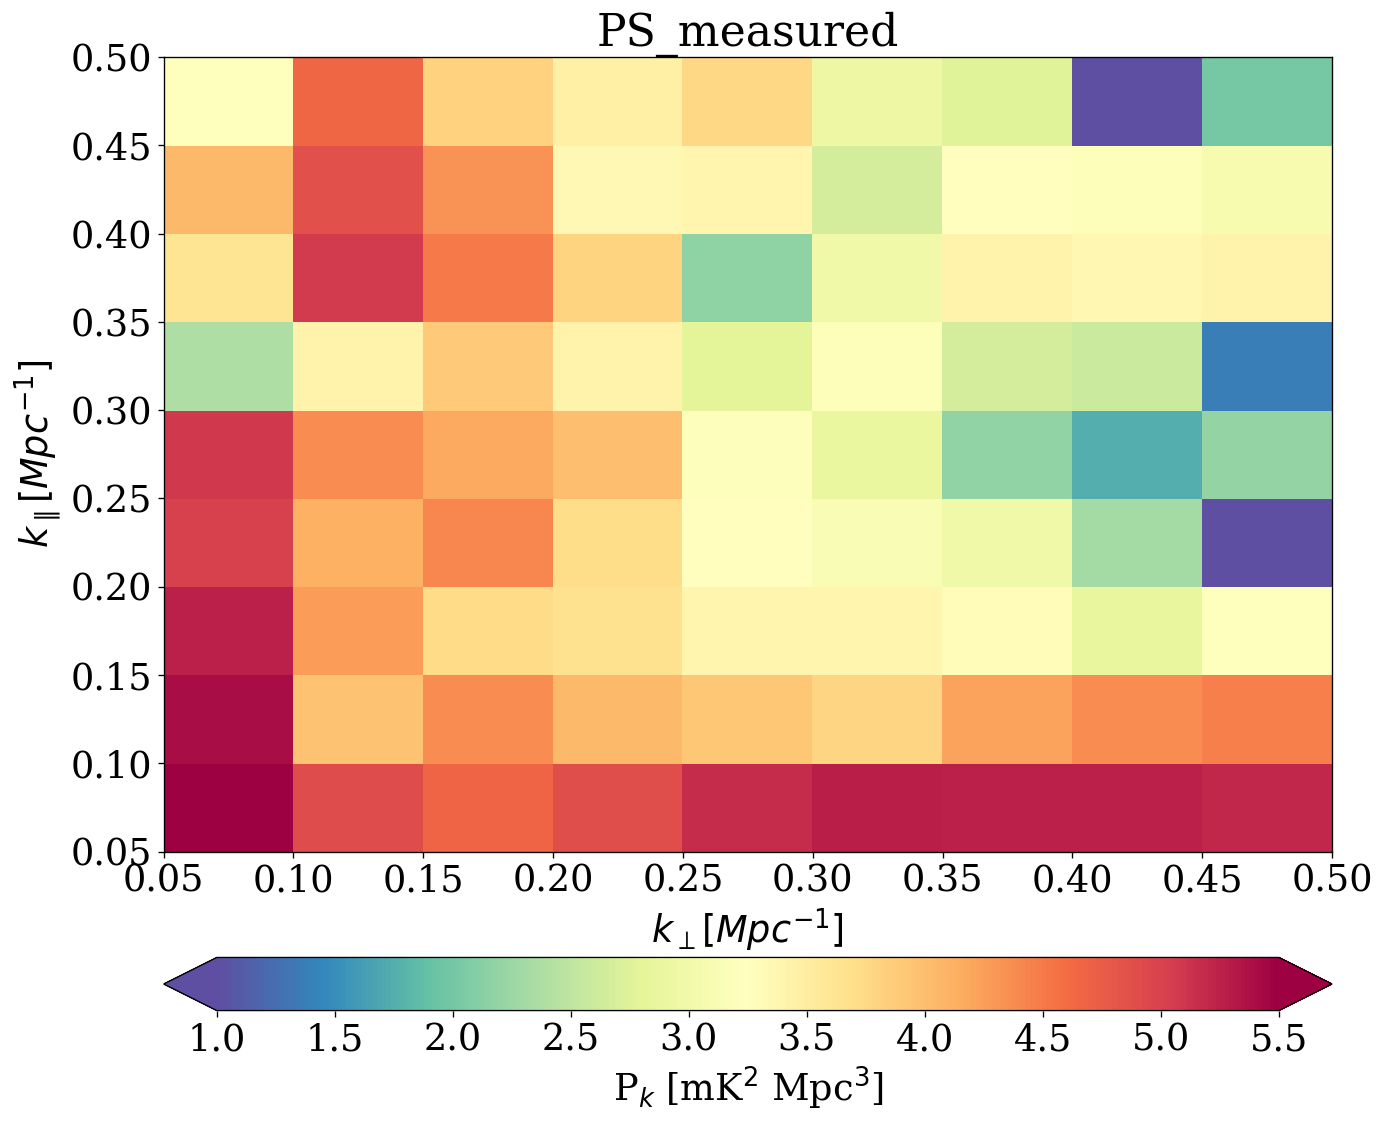

In [116]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=120)

im = ax.pcolormesh(kperp_bins, kpar_bins, np.log10((ps_measured*1e6)),vmin=1,vmax=5.5,cmap = 'Spectral_r')


cbar = fig.colorbar(im, ax=ax, extend='both',pad=0.1, orientation='horizontal')

cbar.ax.minorticks_off()

cbar.set_label(r'P$_{k}$ [mK$^{2}$ Mpc$^{3}$]')
#ax.set_xscale('log')
plt.title('PS_measured')
ax.set_xlabel(r'$k_{\perp} [Mpc^{-1}]$')
ax.set_ylabel(r'$k_{\parallel} [Mpc^{-1}]$')
plt.tight_layout()
plt.show()